In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import matplotlib.dates as mdates

import matplotlib.patches as mpatches
from datetime import datetime
import xarray as xr
import netCDF4 as nc
import glob
import math
import subprocess
from matplotlib import colormaps
import plotly.graph_objs as go

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import seaborn as sns
import csv
import pandas as pd
from scipy.optimize import curve_fit
from math import prod

from metpy.plots import SkewT
from metpy.units import units
from metpy.calc import dewpoint_from_relative_humidity

import numpy as np
from scipy.integrate import trapezoid

import warnings
warnings.simplefilter("ignore", RuntimeWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)

/home/b/b382718/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/seaborn/_statistics.py:31: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.4)
  from scipy.stats import gaussian_kde


In [2]:

#ds_nosip = xr.open_mfdataset('/work/bk1415/b382718/output/steps/nested_run/icon_output/continental_ccn/latent_heat/nosip/steps_2mom_nosip/NWP_LAM_icongrid_DOM04_200006*');
ds_4sip = xr.open_mfdataset('/work/bk1415/b382718/output/steps/nested_run/icon_output/continental_ccn/latent_heat/control/steps_2mom_sip/NWP_LAM_icongrid_DOM04_200006*');
#ds_nohm = xr.open_mfdataset('/work/bk1415/b382718/output/steps/nested_run/icon_output/continental_ccn/latent_heat/nohm/steps_2mom_nohm/NWP_LAM_icongrid_DOM04_200006*');
#ds_norf = xr.open_mfdataset('/work/bk1415/b382718/output/steps/nested_run/icon_output/continental_ccn/latent_heat/norf/steps_2mom_norf/NWP_LAM_icongrid_DOM04_200006*');
#ds_nobr = xr.open_mfdataset('/work/bk1415/b382718/output/steps/nested_run/icon_output/continental_ccn/latent_heat/nobr/steps_2mom_nobr/NWP_LAM_icongrid_DOM04_200006*');
#ds_nosb = xr.open_mfdataset('/work/bk1415/b382718/output/steps/nested_run/icon_output/continental_ccn/latent_heat/nosb/steps_2mom_nosb/NWP_LAM_icongrid_DOM04_200006*');


In [4]:

grid_steps = xr.open_dataset('/work/bk1415/b382718/output/steps/nested_run/icon_output/continental_ccn/latent_heat/control/steps_2mom_sip/domain4_DOM04.nc');

clon_deg = np.degrees(grid_steps.clon)
clat_deg = np.degrees(grid_steps.clat)

print(clon_deg.min().values); print(clon_deg.max().values);
print(clat_deg.min().values); print(clat_deg.max().values);

okla_x, okla_y = np.array([-102., 40.])
#print(okla_x), print(okla_y)
dx_deg = 1.; dy_deg = 1.
left_bound = okla_x - dx_deg
right_bound = okla_x + dx_deg
top_bound = okla_y + dy_deg
bottom_bound = okla_y - dy_deg

print(left_bound), print(right_bound)
print(top_bound), print(bottom_bound)


window_cell = (
    (grid_steps.clat >= np.deg2rad(bottom_bound))
    & (grid_steps.clat <= np.deg2rad(top_bound))
    & (grid_steps.clon >= np.deg2rad(left_bound))
    & (grid_steps.clon <= np.deg2rad(right_bound))
).values

(window_cell_indices,) = np.where(window_cell)

# select cells matching with the area of interest (windows_cell_indices:: matching to that with the area sampled by the aircraft)
window_vertex_indices = (np.unique(grid_steps.vertex_of_cell.isel(cell=window_cell_indices).values) - 1)
print('window_vertex_indices ::',window_vertex_indices)

# select edges matching with the area of interest (corresponding to the windows_cell_indices)
window_edge_indices = (np.unique(grid_steps.edge_of_cell.isel(cell=window_cell_indices).values) - 1)
print('window_edge_indices ::',window_edge_indices)

selected_indices = xr.Dataset(
    {
        "cell": ("cell", window_cell_indices),
        "vertex": ("vertex", window_vertex_indices),
        "edge": ("edge", window_edge_indices),
    }
)

vars_to_renumber = {
    "cell": [
        "adjacent_cell_of_edge",
        "cells_of_vertex",
        "neighbor_cell_index",
    ],
    "vertex": ["vertex_of_cell", "edge_vertices", "vertices_of_vertex"],
    "edge": ["edge_of_cell", "edges_of_vertex"],
}

def reindex_grid(grid, indices, vars_to_renumber):
    new_grid = grid.load().isel(
        cell=indices.cell, vertex=indices.vertex, edge=indices.edge
    )
    for dim, idx in indices.coords.items():
        renumbering = np.full(grid.dims[dim], -2, dtype="int")
        renumbering[idx] = np.arange(len(idx))
        for name in vars_to_renumber[dim]:
            new_grid[name].data = renumbering[new_grid[name].data - 1] + 1
    return new_grid

new_grid_steps = reindex_grid(grid_steps, selected_indices, vars_to_renumber)

mask=np.isin(ds_4sip['ncells'], selected_indices.cell)
mask_cell = mask

-104.03640368667047
-99.96295237559231
37.96466532654236
42.03547401194576
-103.0
-101.0
41.0
39.0
window_vertex_indices :: [ 3428  3433  3434 ... 27926 27927 27928]
window_edge_indices :: [10410 10411 10412 ... 81419 81420 81421]


In [5]:

#ds_nosip['w_vel'] = -1.*ds_nosip.omega/(9.8*ds_nosip.rho)
#ds_nosip['tempc'] = ds_nosip.temp-273.16;
#ds_nosip['lwc_gperm3']  = ds_nosip.qc*ds_nosip.rho*1.e3 # kgperm3 to gperm3
#ds_nosip['tqi'] = ds_nosip.qi+ds_nosip.qs+ds_nosip.qg+ds_nosip.qh
#ds_nosip['tq'] = ds_nosip.qc+ds_nosip.qi+ds_nosip.qs+ds_nosip.qg+ds_nosip.qh
#ds_nosip['ciwc_gperm3'] = ds_nosip.qi*ds_nosip.rho*1.e3 # kgperm3 to gperm3
#ds_nosip['tiwc_gperm3'] = (ds_nosip.qi+ds_nosip.qs+ds_nosip.qg+ds_nosip.qh)*ds_nosip.rho*1.e3 # kgperm3 to gperm3
#ds_nosip['cdnc_percm3'] = ds_nosip.qnc*ds_nosip.rho*1.e-6  # perkg to percm3
#ds_nosip['inc_perl'] = (ds_nosip.qni+ds_nosip.qns+ds_nosip.qng+ds_nosip.qnh)*ds_nosip.rho*1.e-3 # perkg to perl

ds_4sip['w_vel'] = -1.*ds_4sip.omega/(9.8*ds_4sip.rho)
ds_4sip['tempc'] = ds_4sip.temp-273.16;
ds_4sip['lwc_gperm3']  = ds_4sip.qc*ds_4sip.rho*1.e3 # kgperm3 to gperm3
ds_4sip['tqi'] = ds_4sip.qi+ds_4sip.qs+ds_4sip.qg+ds_4sip.qh
ds_4sip['tq'] = ds_4sip.qc+ds_4sip.qi+ds_4sip.qs+ds_4sip.qg+ds_4sip.qh
ds_4sip['ciwc_gperm3'] = ds_4sip.qi*ds_4sip.rho*1.e3 # kgperm3 to gperm3
ds_4sip['tiwc_gperm3'] = (ds_4sip.qi+ds_4sip.qs+ds_4sip.qg+ds_4sip.qh)*ds_4sip.rho*1.e3 # kgperm3 to gperm3
ds_4sip['cdnc_percm3'] = ds_4sip.qnc*ds_4sip.rho*1.e-6  # perkg to percm3
ds_4sip['inc_perl'] = (ds_4sip.qni+ds_4sip.qns+ds_4sip.qng+ds_4sip.qnh)*ds_4sip.rho*1.e-3 # perkg to perl

#ds_norf['w_vel'] = -1.*ds_norf.omega/(9.8*ds_norf.rho)
#ds_norf['tempc'] = ds_norf.temp-273.16;
#ds_norf['lwc_gperm3']  = ds_norf.qc*ds_norf.rho*1.e3 # kgperm3 to gperm3
#ds_norf['tqi'] = ds_norf.qi+ds_norf.qs+ds_norf.qg+ds_norf.qh
#ds_norf['tq'] = ds_norf.qc+ds_norf.qi+ds_norf.qs+ds_norf.qg+ds_norf.qh
#ds_norf['ciwc_gperm3'] = ds_norf.qi*ds_norf.rho*1.e3 # kgperm3 to gperm3
#ds_norf['tiwc_gperm3'] = (ds_norf.qi+ds_norf.qs+ds_norf.qg+ds_norf.qh)*ds_norf.rho*1.e3 # kgperm3 to gperm3
#ds_norf['cdnc_percm3'] = ds_norf.qnc*ds_norf.rho*1.e-6  # perkg to percm3
#ds_norf['inc_perl'] = (ds_norf.qni+ds_norf.qns+ds_norf.qng+ds_norf.qnh)*ds_norf.rho*1.e-3 # perkg to perl

#ds_nohm['w_vel'] = -1.*ds_nohm.omega/(9.8*ds_nohm.rho)
#ds_nohm['tempc'] = ds_nohm.temp-273.16;
#ds_nohm['lwc_gperm3']  = ds_nohm.qc*ds_nohm.rho*1.e3 # kgperm3 to gperm3
#ds_nohm['tqi'] = ds_nohm.qi+ds_nohm.qs+ds_nohm.qg+ds_nohm.qh
#ds_nohm['tq'] = ds_nohm.qc+ds_nohm.qi+ds_nohm.qs+ds_nohm.qg+ds_nohm.qh
#ds_nohm['ciwc_gperm3'] = ds_nohm.qi*ds_nohm.rho*1.e3 # kgperm3 to gperm3
#ds_nohm['tiwc_gperm3'] = (ds_nohm.qi+ds_nohm.qs+ds_nohm.qg+ds_nohm.qh)*ds_nohm.rho*1.e3 # kgperm3 to gperm3
#ds_nohm['cdnc_percm3'] = ds_nohm.qnc*ds_nohm.rho*1.e-6  # perkg to percm3
#ds_nohm['inc_perl'] = (ds_nohm.qni+ds_nohm.qns+ds_nohm.qng+ds_nohm.qnh)*ds_nohm.rho*1.e-3 # perkg to perl

#ds_nobr['w_vel'] = -1.*ds_nobr.omega/(9.8*ds_nobr.rho)
#ds_nobr['tempc'] = ds_nobr.temp-273.16;
#ds_nobr['lwc_gperm3']  = ds_nobr.qc*ds_nobr.rho*1.e3 # kgperm3 to gperm3
#ds_nobr['tqi'] = ds_nobr.qi+ds_nobr.qs+ds_nobr.qg+ds_nobr.qh
#ds_nobr['tq'] = ds_nobr.qc+ds_nobr.qi+ds_nobr.qs+ds_nobr.qg+ds_nobr.qh
#ds_nobr['ciwc_gperm3'] = ds_nobr.qi*ds_nobr.rho*1.e3 # kgperm3 to gperm3
#ds_nobr['tiwc_gperm3'] = (ds_nobr.qi+ds_nobr.qs+ds_nobr.qg+ds_nobr.qh)*ds_nobr.rho*1.e3 # kgperm3 to gperm3
#ds_nobr['cdnc_percm3'] = ds_nobr.qnc*ds_nobr.rho*1.e-6  # perkg to percm3
#ds_nobr['inc_perl'] = (ds_nobr.qni+ds_nobr.qns+ds_nobr.qng+ds_nobr.qnh)*ds_nobr.rho*1.e-3 # perkg to perl

#ds_nosb['w_vel'] = -1.*ds_nosb.omega/(9.8*ds_nosb.rho)
#ds_nosb['tempc'] = ds_nosb.temp-273.16;
#ds_nosb['lwc_gperm3']  = ds_nosb.qc*ds_nosb.rho*1.e3 # kgperm3 to gperm3
#ds_nosb['tqi'] = ds_nosb.qi+ds_nosb.qs+ds_nosb.qg+ds_nosb.qh
#ds_nosb['tq'] = ds_nosb.qc+ds_nosb.qi+ds_nosb.qs+ds_nosb.qg+ds_nosb.qh
#ds_nosb['ciwc_gperm3'] = ds_nosb.qi*ds_nosb.rho*1.e3 # kgperm3 to gperm3
#ds_nosb['tiwc_gperm3'] = (ds_nosb.qi+ds_nosb.qs+ds_nosb.qg+ds_nosb.qh)*ds_nosb.rho*1.e3 # kgperm3 to gperm3
#ds_nosb['cdnc_percm3'] = ds_nosb.qnc*ds_nosb.rho*1.e-6  # perkg to percm3
#ds_nosb['inc_perl'] = (ds_nosb.qni+ds_nosb.qns+ds_nosb.qng+ds_nosb.qnh)*ds_nosb.rho*1.e-3 # perkg to perl


In [7]:
aircraft_starttime='2000-06-19T20:00:00.000000000'
aircraft_endtime='2000-06-20T02:00:00.000000000'

#ds_nosip_new = ds_nosip.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))
ds_4sip_new = ds_4sip.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))
#ds_norf_new = ds_norf.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))
#ds_nohm_new = ds_nohm.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))
#ds_nobr_new = ds_nobr.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))
#ds_nosb_new = ds_nosb.sel(ncells=mask,time=slice(aircraft_starttime, aircraft_endtime))


In [9]:

w_thres = 1.
###### Without SIP
# lwc gperm3
#filt_lwc_up_perl = xr.where((ds_nosip_new.lwc_gperm3 > 1.e-6) & (ds_nosip_new.w_vel > w_thres), ds_nosip_new.lwc_gperm3, np.nan)
#filt_lwc_dn_perl = xr.where((ds_nosip_new.lwc_gperm3 > 1.e-6) & (ds_nosip_new.w_vel < -1.*w_thres), ds_nosip_new.lwc_gperm3, np.nan)
#filt_lwc_st_perl = xr.where((ds_nosip_new.lwc_gperm3 > 1.e-6) & (np.abs(ds_nosip_new.w_vel) < w_thres), ds_nosip_new.lwc_gperm3, np.nan)

#lwc_up_nosip = filt_lwc_up_perl.mean(dim=('time','ncells'))
#lwc_dn_nosip = filt_lwc_dn_perl.mean(dim=('time','ncells'))
#lwc_st_nosip = filt_lwc_st_perl.mean(dim=('time','ncells'))

#tempc_nosip = ds_nosip_new.tempc.mean(dim=('time','ncells'))

# iwc gperm3
#filt_tiwc_up_perl = xr.where((ds_nosip_new.tiwc_gperm3 > 1.e-6) & (ds_nosip_new.w_vel > w_thres), ds_nosip_new.tiwc_gperm3, np.nan)
#filt_tiwc_dn_perl = xr.where((ds_nosip_new.tiwc_gperm3 > 1.e-6) & (ds_nosip_new.w_vel < -1.*w_thres), ds_nosip_new.tiwc_gperm3, np.nan)
#filt_tiwc_st_perl = xr.where((ds_nosip_new.tiwc_gperm3 > 1.e-6) & (np.abs(ds_nosip_new.w_vel) < w_thres), ds_nosip_new.tiwc_gperm3, np.nan)

#tiwc_up_nosip = filt_tiwc_up_perl.mean(dim=('time','ncells'))
#tiwc_dn_nosip = filt_tiwc_dn_perl.mean(dim=('time','ncells'))
#tiwc_st_nosip = filt_tiwc_st_perl.mean(dim=('time','ncells'))

# CDNC percm3
#filt_cdnc_up_perl = xr.where((ds_nosip_new.cdnc_percm3 > 1.e-6) & (ds_nosip_new.w_vel > w_thres), ds_nosip_new.cdnc_percm3, np.nan)
#filt_cdnc_dn_perl = xr.where((ds_nosip_new.cdnc_percm3 > 1.e-6) & (ds_nosip_new.w_vel < -1.*w_thres), ds_nosip_new.cdnc_percm3, np.nan)
#filt_cdnc_st_perl = xr.where((ds_nosip_new.cdnc_percm3 > 1.e-6) & (np.abs(ds_nosip_new.w_vel) < w_thres), ds_nosip_new.cdnc_percm3, np.nan)

#cdnc_up_nosip = filt_cdnc_up_perl.mean(dim=('time','ncells'))
#cdnc_dn_nosip = filt_cdnc_dn_perl.mean(dim=('time','ncells'))
#cdnc_st_nosip = filt_cdnc_st_perl.mean(dim=('time','ncells'))


###### With SIP
# lwc gperm3
filt_lwc_up_perl = xr.where((ds_4sip_new.lwc_gperm3 > 1.e-6) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.lwc_gperm3, np.nan)
filt_lwc_dn_perl = xr.where((ds_4sip_new.lwc_gperm3 > 1.e-6) & (ds_4sip_new.w_vel < -1.*w_thres), ds_4sip_new.lwc_gperm3, np.nan)
filt_lwc_st_perl = xr.where((ds_4sip_new.lwc_gperm3 > 1.e-6) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.lwc_gperm3, np.nan)

lwc_up_sip = filt_lwc_up_perl.mean(dim=('time','ncells'))
lwc_dn_sip = filt_lwc_dn_perl.mean(dim=('time','ncells'))
lwc_st_sip = filt_lwc_st_perl.mean(dim=('time','ncells'))

tempc_sip = ds_4sip_new.tempc.mean(dim=('time','ncells'))

# iwc gperm3
filt_tiwc_up_perl = xr.where((ds_4sip_new.tiwc_gperm3 > 1.e-6) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.tiwc_gperm3, np.nan)
filt_tiwc_dn_perl = xr.where((ds_4sip_new.tiwc_gperm3 > 1.e-6) & (ds_4sip_new.w_vel < -1.*w_thres), ds_4sip_new.tiwc_gperm3, np.nan)
filt_tiwc_st_perl = xr.where((ds_4sip_new.tiwc_gperm3 > 1.e-6) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.tiwc_gperm3, np.nan)

tiwc_up_sip = filt_tiwc_up_perl.mean(dim=('time','ncells'))
tiwc_dn_sip = filt_tiwc_dn_perl.mean(dim=('time','ncells'))
tiwc_st_sip = filt_tiwc_st_perl.mean(dim=('time','ncells'))

# CDNC percm3
filt_cdnc_up_perl = xr.where((ds_4sip_new.cdnc_percm3 > 1.e-6) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.cdnc_percm3, np.nan)
filt_cdnc_dn_perl = xr.where((ds_4sip_new.cdnc_percm3 > 1.e-6) & (ds_4sip_new.w_vel < -1.*w_thres), ds_4sip_new.cdnc_percm3, np.nan)
filt_cdnc_st_perl = xr.where((ds_4sip_new.cdnc_percm3 > 1.e-6) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.cdnc_percm3, np.nan)

cdnc_up_sip = filt_cdnc_up_perl.mean(dim=('time','ncells'))
cdnc_dn_sip = filt_cdnc_dn_perl.mean(dim=('time','ncells'))
cdnc_st_sip = filt_cdnc_st_perl.mean(dim=('time','ncells'))


In [10]:

####================== Boxplot of ICON-LWC [4-SIP]
w_thres = 1.
thres_q = 1.e-6
###### Without SIP
# lwc gperm3
lwc_4sip_up_gperm3 = xr.where((ds_4sip_new.qc > thres_q) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.lwc_gperm3, np.nan)
lwc_4sip_dn_gperm3 = xr.where((ds_4sip_new.qc > thres_q) & (ds_4sip_new.w_vel > -1.*w_thres), ds_4sip_new.lwc_gperm3, np.nan)
lwc_4sip_st_gperm3 = xr.where((ds_4sip_new.qc > thres_q) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.lwc_gperm3, np.nan)
tempc_4sip = ds_4sip_new.tempc

lwc_4sip_up_gperm3 = lwc_4sip_up_gperm3.values.flatten()
lwc_4sip_dn_gperm3 = lwc_4sip_dn_gperm3.values.flatten()
lwc_4sip_st_gperm3 = lwc_4sip_st_gperm3.values.flatten()
tempc_4sip = tempc_4sip.values.flatten()

df_lwc_4sip = pd.DataFrame({
    'lwc_up': lwc_4sip_up_gperm3,
    'lwc_dn': lwc_4sip_dn_gperm3,
    'lwc_st': lwc_4sip_st_gperm3,
    'tempc': tempc_4sip,
})

tempc_bin = np.arange(-50., 20., 5.)  # Temperature bins 
tempc_bin = np.sort(tempc_bin)

df_lwc_4sip['temp_bin'] = np.digitize(df_lwc_4sip['tempc'], bins=tempc_bin, right=False)

bin_edges = np.concatenate([tempc_bin - 2, [tempc_bin[-1] + 2]])  
df_lwc_4sip['temp_bin'] = bin_edges[df_lwc_4sip['temp_bin']]

df_lwc_up_4sip = df_lwc_4sip[['lwc_up', 'temp_bin']].dropna()
df_lwc_dn_4sip = df_lwc_4sip[['lwc_dn', 'temp_bin']].dropna()
df_lwc_st_4sip = df_lwc_4sip[['lwc_st', 'temp_bin']].dropna()

df_lwc_up_4sip = df_lwc_up_4sip.dropna(subset=['temp_bin'])
df_lwc_dn_4sip = df_lwc_dn_4sip.dropna(subset=['temp_bin'])
df_lwc_st_4sip = df_lwc_st_4sip.dropna(subset=['temp_bin'])

lwc_4sip_up_by_bin = [df_lwc_up_4sip[df_lwc_up_4sip['temp_bin'] == temp]['lwc_up'].values for temp in bin_edges]
lwc_4sip_dn_by_bin = [df_lwc_dn_4sip[df_lwc_dn_4sip['temp_bin'] == temp]['lwc_dn'].values for temp in bin_edges]
lwc_4sip_st_by_bin = [df_lwc_st_4sip[df_lwc_st_4sip['temp_bin'] == temp]['lwc_st'].values for temp in bin_edges]


In [11]:

####================== Boxplot of ICON-LWC [3-SIP]
w_thres = 1.
thres_q = 1.e-6
###### Without SIP
# lwc gperm3
cdnc_4sip_up_percm3 = xr.where((ds_4sip_new.qc > thres_q) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.cdnc_percm3, np.nan)
cdnc_4sip_dn_percm3 = xr.where((ds_4sip_new.qc > thres_q) & (ds_4sip_new.w_vel > -1.*w_thres), ds_4sip_new.cdnc_percm3, np.nan)
cdnc_4sip_st_percm3 = xr.where((ds_4sip_new.qc > thres_q) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.cdnc_percm3, np.nan)
tempc_4sip = ds_4sip_new.tempc

cdnc_4sip_up_percm3 = cdnc_4sip_up_percm3.values.flatten()
cdnc_4sip_dn_percm3 = cdnc_4sip_dn_percm3.values.flatten()
cdnc_4sip_st_percm3 = cdnc_4sip_st_percm3.values.flatten()
tempc_4sip = tempc_4sip.values.flatten()

df_cdnc_4sip = pd.DataFrame({
    'cdnc_up': cdnc_4sip_up_percm3,
    'cdnc_dn': cdnc_4sip_dn_percm3,
    'cdnc_st': cdnc_4sip_st_percm3,
    'tempc': tempc_4sip,
})

tempc_bin = np.arange(-50., 20., 5.)  # Temperature bins 
tempc_bin = np.sort(tempc_bin)

df_cdnc_4sip['temp_bin'] = np.digitize(df_cdnc_4sip['tempc'], bins=tempc_bin, right=False)

bin_edges = np.concatenate([tempc_bin - 2, [tempc_bin[-1] + 2]])  
df_cdnc_4sip['temp_bin'] = bin_edges[df_cdnc_4sip['temp_bin']]

df_cdnc_up_4sip = df_cdnc_4sip[['cdnc_up', 'temp_bin']].dropna()
df_cdnc_dn_4sip = df_cdnc_4sip[['cdnc_dn', 'temp_bin']].dropna()
df_cdnc_st_4sip = df_cdnc_4sip[['cdnc_st', 'temp_bin']].dropna()

df_cdnc_up_4sip = df_cdnc_up_4sip.dropna(subset=['temp_bin'])
df_cdnc_dn_4sip = df_cdnc_dn_4sip.dropna(subset=['temp_bin'])
df_cdnc_st_4sip = df_cdnc_st_4sip.dropna(subset=['temp_bin'])

cdnc_4sip_up_by_bin = [df_cdnc_up_4sip[df_cdnc_up_4sip['temp_bin'] == temp]['cdnc_up'].values for temp in bin_edges]
cdnc_4sip_dn_by_bin = [df_cdnc_dn_4sip[df_cdnc_dn_4sip['temp_bin'] == temp]['cdnc_dn'].values for temp in bin_edges]
cdnc_4sip_st_by_bin = [df_cdnc_st_4sip[df_cdnc_st_4sip['temp_bin'] == temp]['cdnc_st'].values for temp in bin_edges]


In [12]:

####================== Boxplot of ICON-LWC [3-SIP]
w_thres = 1.
thres_q = 1.e-5
###### 4-SIP
# lwc gperm3
inc_4sip_up_perl = xr.where((ds_4sip_new.tqi > thres_q) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.inc_perl, np.nan)
inc_4sip_dn_perl = xr.where((ds_4sip_new.tqi > thres_q) & (ds_4sip_new.w_vel > -1.*w_thres), ds_4sip_new.inc_perl, np.nan)
inc_4sip_st_perl = xr.where((ds_4sip_new.tqi > thres_q) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.inc_perl, np.nan)
tempc_4sip = ds_4sip_new.tempc

inc_4sip_up_perl = inc_4sip_up_perl.values.flatten()
inc_4sip_dn_perl = inc_4sip_dn_perl.values.flatten()
inc_4sip_st_perl = inc_4sip_st_perl.values.flatten()
tempc_4sip = tempc_4sip.values.flatten()

df_inc_4sip = pd.DataFrame({
    'inc_up': inc_4sip_up_perl,
    'inc_dn': inc_4sip_dn_perl,
    'inc_st': inc_4sip_st_perl,
    'tempc': tempc_4sip,
})

tempc_bin = np.arange(-50., 20., 5.)  # Temperature bins 
tempc_bin = np.sort(tempc_bin)

df_inc_4sip['temp_bin'] = np.digitize(df_inc_4sip['tempc'], bins=tempc_bin, right=False)

bin_edges = np.concatenate([tempc_bin - 2, [tempc_bin[-1] + 2]])  
df_inc_4sip['temp_bin'] = bin_edges[df_inc_4sip['temp_bin']]

df_inc_up_4sip = df_inc_4sip[['inc_up', 'temp_bin']].dropna()
df_inc_dn_4sip = df_inc_4sip[['inc_dn', 'temp_bin']].dropna()
df_inc_st_4sip = df_inc_4sip[['inc_st', 'temp_bin']].dropna()

df_inc_up_4sip = df_inc_up_4sip.dropna(subset=['temp_bin'])
df_inc_dn_4sip = df_inc_dn_4sip.dropna(subset=['temp_bin'])
df_inc_st_4sip = df_inc_st_4sip.dropna(subset=['temp_bin'])

inc_4sip_up_by_bin = [df_inc_up_4sip[df_inc_up_4sip['temp_bin'] == temp]['inc_up'].values for temp in bin_edges]
inc_4sip_dn_by_bin = [df_inc_dn_4sip[df_inc_dn_4sip['temp_bin'] == temp]['inc_dn'].values for temp in bin_edges]
inc_4sip_st_by_bin = [df_inc_st_4sip[df_inc_st_4sip['temp_bin'] == temp]['inc_st'].values for temp in bin_edges]


In [241]:

####================== Boxplot of ICON-LWC [3-SIP]
w_thres = 1.
thres_q = 1.e-9
###### Without SIP
# lwc gperm3
iwc_4sip_up_gperm3 = xr.where((ds_4sip_new.tqi > thres_q) & (ds_4sip_new.w_vel > w_thres), ds_4sip_new.tiwc_gperm3, np.nan)
iwc_4sip_dn_gperm3 = xr.where((ds_4sip_new.tqi > thres_q) & (ds_4sip_new.w_vel > -1.*w_thres), ds_4sip_new.tiwc_gperm3, np.nan)
iwc_4sip_st_gperm3 = xr.where((ds_4sip_new.tqi > thres_q) & (np.abs(ds_4sip_new.w_vel) < w_thres), ds_4sip_new.tiwc_gperm3, np.nan)
tempc_4sip = ds_4sip_new.tempc

iwc_4sip_up_gperm3 = iwc_4sip_up_gperm3.values.flatten()
iwc_4sip_dn_gperm3 = iwc_4sip_dn_gperm3.values.flatten()
iwc_4sip_st_gperm3 = iwc_4sip_st_gperm3.values.flatten()
tempc_4sip = tempc_4sip.values.flatten()

df_iwc_4sip = pd.DataFrame({
    'iwc_up': iwc_4sip_up_gperm3,
    'iwc_dn': iwc_4sip_dn_gperm3,
    'iwc_st': iwc_4sip_st_gperm3,
    'tempc': tempc_4sip,
})

tempc_bin = np.arange(-50., 20., 5.)  # Temperature bins 
tempc_bin = np.sort(tempc_bin)

df_iwc_4sip['temp_bin'] = np.digitize(df_iwc_4sip['tempc'], bins=tempc_bin, right=False)

bin_edges = np.concatenate([tempc_bin - 2, [tempc_bin[-1] + 2]])  
df_iwc_4sip['temp_bin'] = bin_edges[df_iwc_4sip['temp_bin']]

df_iwc_up_4sip = df_iwc_4sip[['iwc_up', 'temp_bin']].dropna()
df_iwc_dn_4sip = df_iwc_4sip[['iwc_dn', 'temp_bin']].dropna()
df_iwc_st_4sip = df_iwc_4sip[['iwc_st', 'temp_bin']].dropna()

df_iwc_up_4sip = df_iwc_up_4sip.dropna(subset=['temp_bin'])
df_iwc_dn_4sip = df_iwc_dn_4sip.dropna(subset=['temp_bin'])
df_iwc_st_4sip = df_iwc_st_4sip.dropna(subset=['temp_bin'])

iwc_4sip_up_by_bin = [df_iwc_up_4sip[df_iwc_up_4sip['temp_bin'] == temp]['iwc_up'].values for temp in bin_edges]
iwc_4sip_dn_by_bin = [df_iwc_dn_4sip[df_iwc_dn_4sip['temp_bin'] == temp]['iwc_dn'].values for temp in bin_edges]
iwc_4sip_st_by_bin = [df_iwc_st_4sip[df_iwc_st_4sip['temp_bin'] == temp]['iwc_st'].values for temp in bin_edges]


In [14]:

# Open the dataset
import xarray as xr
import netCDF4

ds_air_obs = netCDF4.Dataset('/work/bk1415/b382718/output/steps/observations/aircraft_data/T28_STEPS2000_756.nc', 'r')
#print(ds_air_obs.variables)  # View available variables

ds_obs_tim = ds_air_obs.variables['Time'][:]
ds_obs_hrs = ds_air_obs.variables['TIME_HOURS_20Hz'][:]  
ds_obs_min = ds_air_obs.variables['TIME_MINUTES_20Hz'][:]  
ds_obs_sec = ds_air_obs.variables['TIME_SECONDS_20Hz'][:]                                  
ds_obs_temp_rm = ds_air_obs.variables['TEMPERATURE_ROSEMOUNT_SENSOR'][:]                 # C
ds_obs_temp_rf = ds_air_obs.variables['TEMPERATURE_REVERSE_FLOW_SENSOR'][:]              # C
ds_obs_air_den = ds_air_obs.variables['DENSITY_AIR'][:]                                  # kg/m3
ds_obs_no_conc = ds_air_obs.variables['NO_CONCENTRATION'][:]                             # ppb
ds_obs_fssp_lwc = ds_air_obs.variables['FSSP_LIQUID_WATER'][:]                           # g/m3
ds_obs_tot_cnt = ds_air_obs.variables['FSSP_TOTAL_COUNTS'][:]                            # count
ds_obs_fssp_diam = ds_air_obs.variables['FSSP_AVERAGE_DIAMETER'][:]                      # µm
ds_obs_fssp_tot_conc = ds_air_obs.variables['FSSP_TOTAL_PARTICLE_CONCENTRATION'][:]      # count/cm3
ds_obs_fssp_eq_diam = ds_air_obs.variables['FSSP_EQUIVALENT_DIAMETER'][:]                # µm
ds_obs_fssp_qc = ds_air_obs.variables['FSSP_LIQUID_WATER_MIXING_RATIO'][:]               # gperkg
ds_obs_w = ds_air_obs.variables['UPDRAFT'][:]               # gperkg


###
mask_rho = (ds_obs_air_den < 0.5)
ds_obs_air_den[mask_rho] = np.nan
ds_obs_avg_rho = np.nanmean(ds_obs_air_den, axis=1) 
###

###
#mask_diam = (ds_obs_fssp_diam > 100.)
#ds_obs_fssp_diam[mask_diam] = np.nan
ds_obs_avg_diam = np.nanmean(ds_obs_fssp_diam, axis=1) 
###

###
#mask_tot_conc = (ds_obs_fssp_tot_conc > 2500.)
#ds_obs_fssp_tot_conc[mask_tot_conc] = np.nan
ds_obs_avg_tot_conc = np.nanmean(ds_obs_fssp_tot_conc, axis=1) 
###

###
#mask_eq_diam = (ds_obs_fssp_eq_diam > 100.)
#ds_obs_fssp_eq_diam[mask_eq_diam] = np.nan
ds_obs_avg_eqv_diam = np.nanmean(ds_obs_fssp_eq_diam, axis=1) 
###

###
#mask_qc = (ds_obs_fssp_qc > 25.)
#ds_obs_fssp_qc[mask_qc] = np.nan
ds_obs_avg_qc = np.nanmean(ds_obs_fssp_qc, axis=1) 
###

###
#mask_lwc = (ds_obs_fssp_lwc > 6.)
#ds_obs_fssp_lwc[mask_lwc] = np.nan
ds_obs_avg_lwc = np.nanmean(ds_obs_fssp_lwc, axis=1) 
###


###
mask_w = (np.abs(ds_obs_w) > 20.)
ds_obs_w[mask_w] = np.nan
ds_obs_avg_w = np.nanmean(ds_obs_w, axis=1) 
###

ds_obs_avg_tc = np.nanmean(ds_obs_temp_rm, axis=1)

####
w_thres = 1. 
####
filt_lwc_fssp_up_cond = (ds_obs_avg_lwc > 1.e-4) & (ds_obs_avg_w > w_thres)
filt_lwc_fssp_dn_cond = (ds_obs_avg_lwc > 1.e-4) & (ds_obs_avg_w < -1.*w_thres)
filt_lwc_fssp_st_cond = (ds_obs_avg_lwc > 1.e-4) & (np.abs(ds_obs_avg_w) < w_thres)

fssp_lwc_up = np.where(filt_lwc_fssp_up_cond, ds_obs_avg_lwc, np.nan)
fssp_lwc_dn = np.where(filt_lwc_fssp_dn_cond, ds_obs_avg_lwc, np.nan)
fssp_lwc_st = np.where(filt_lwc_fssp_st_cond, ds_obs_avg_lwc, np.nan)

#####
filt_avg_diam_up_cond = (ds_obs_avg_diam > 0.) & (ds_obs_avg_w > w_thres)
filt_avg_diam_dn_cond = (ds_obs_avg_diam > 0.) & (ds_obs_avg_w < -1.*w_thres)
filt_avg_diam_st_cond = (ds_obs_avg_diam > 0.) & (np.abs(ds_obs_avg_w) < w_thres)

fssp_avg_diam_up = np.where(filt_avg_diam_up_cond, ds_obs_avg_diam, np.nan)
fssp_avg_diam_dn = np.where(filt_avg_diam_dn_cond, ds_obs_avg_diam, np.nan)
fssp_avg_diam_st = np.where(filt_avg_diam_st_cond, ds_obs_avg_diam, np.nan)

###
filt_eqv_diam_up_cond = (ds_obs_avg_eqv_diam > 0.) & (ds_obs_avg_w > w_thres)
filt_eqv_diam_dn_cond = (ds_obs_avg_eqv_diam > 0.) & (ds_obs_avg_w < -1.*w_thres)
filt_eqv_diam_st_cond = (ds_obs_avg_eqv_diam > 0.) & (np.abs(ds_obs_avg_w) < w_thres)

fssp_avg_eqv_diam_up = np.where(filt_eqv_diam_up_cond, ds_obs_avg_eqv_diam, np.nan)
fssp_avg_eqv_diam_dn = np.where(filt_eqv_diam_dn_cond, ds_obs_avg_eqv_diam, np.nan)
fssp_avg_eqv_diam_st = np.where(filt_eqv_diam_st_cond, ds_obs_avg_eqv_diam, np.nan)

###
filt_tot_conc_up_cond = (ds_obs_avg_tot_conc > 0.) & (ds_obs_avg_w > w_thres)
filt_tot_conc_dn_cond = (ds_obs_avg_tot_conc > 0.) & (ds_obs_avg_w < -1.*w_thres)
filt_tot_conc_st_cond = (ds_obs_avg_tot_conc > 0.) & (np.abs(ds_obs_avg_w) < w_thres)

fssp_tot_conc_up = np.where(filt_tot_conc_up_cond, ds_obs_avg_tot_conc, np.nan)
fssp_tot_conc_dn = np.where(filt_tot_conc_dn_cond, ds_obs_avg_tot_conc, np.nan)
fssp_tot_conc_st = np.where(filt_tot_conc_st_cond, ds_obs_avg_tot_conc, np.nan)


###
df_t28_obs = pd.DataFrame({
    'tempc': ds_obs_avg_tc,
    'w_vel': ds_obs_avg_w,
    'air_den':ds_obs_avg_rho,
    'fssp_mean_diam':ds_obs_avg_diam,
    'fssp_eqv_diam':ds_obs_avg_eqv_diam,
    'fssp_qc':ds_obs_avg_qc,
    'fssp_lwc':ds_obs_avg_lwc,
    'fssp_tot_conc':ds_obs_avg_tot_conc,
    'lwc_up':fssp_lwc_up,
    'lwc_dn':fssp_lwc_dn,
    'lwc_st':fssp_lwc_st,
    'avg_diam_up':fssp_avg_diam_up,
    'avg_diam_dn':fssp_avg_diam_dn,
    'avg_diam_st':fssp_avg_diam_st,
    'eqv_diam_up':fssp_avg_eqv_diam_up,
    'eqv_diam_dn':fssp_avg_eqv_diam_dn,
    'eqv_diam_st':fssp_avg_eqv_diam_st,
    'tot_conc_up':fssp_tot_conc_up,
    'tot_conc_dn':fssp_tot_conc_dn,
    'tot_conc_st':fssp_tot_conc_st 
})

#plt.plot(ds_obs_fssp_qc,ds_obs_temp_rm)
#plt.plot(ds_obs_avg_lwc,ds_obs_avg_tc)
#plt.ylim(0,-30)
#plt.grid(True)

print(df_t28_obs.shape)

(5306, 20)


In [15]:

print(df_t28_obs['tempc'].min())
print(df_t28_obs['tempc'].max())

-16.288616180419922
29.806133270263672


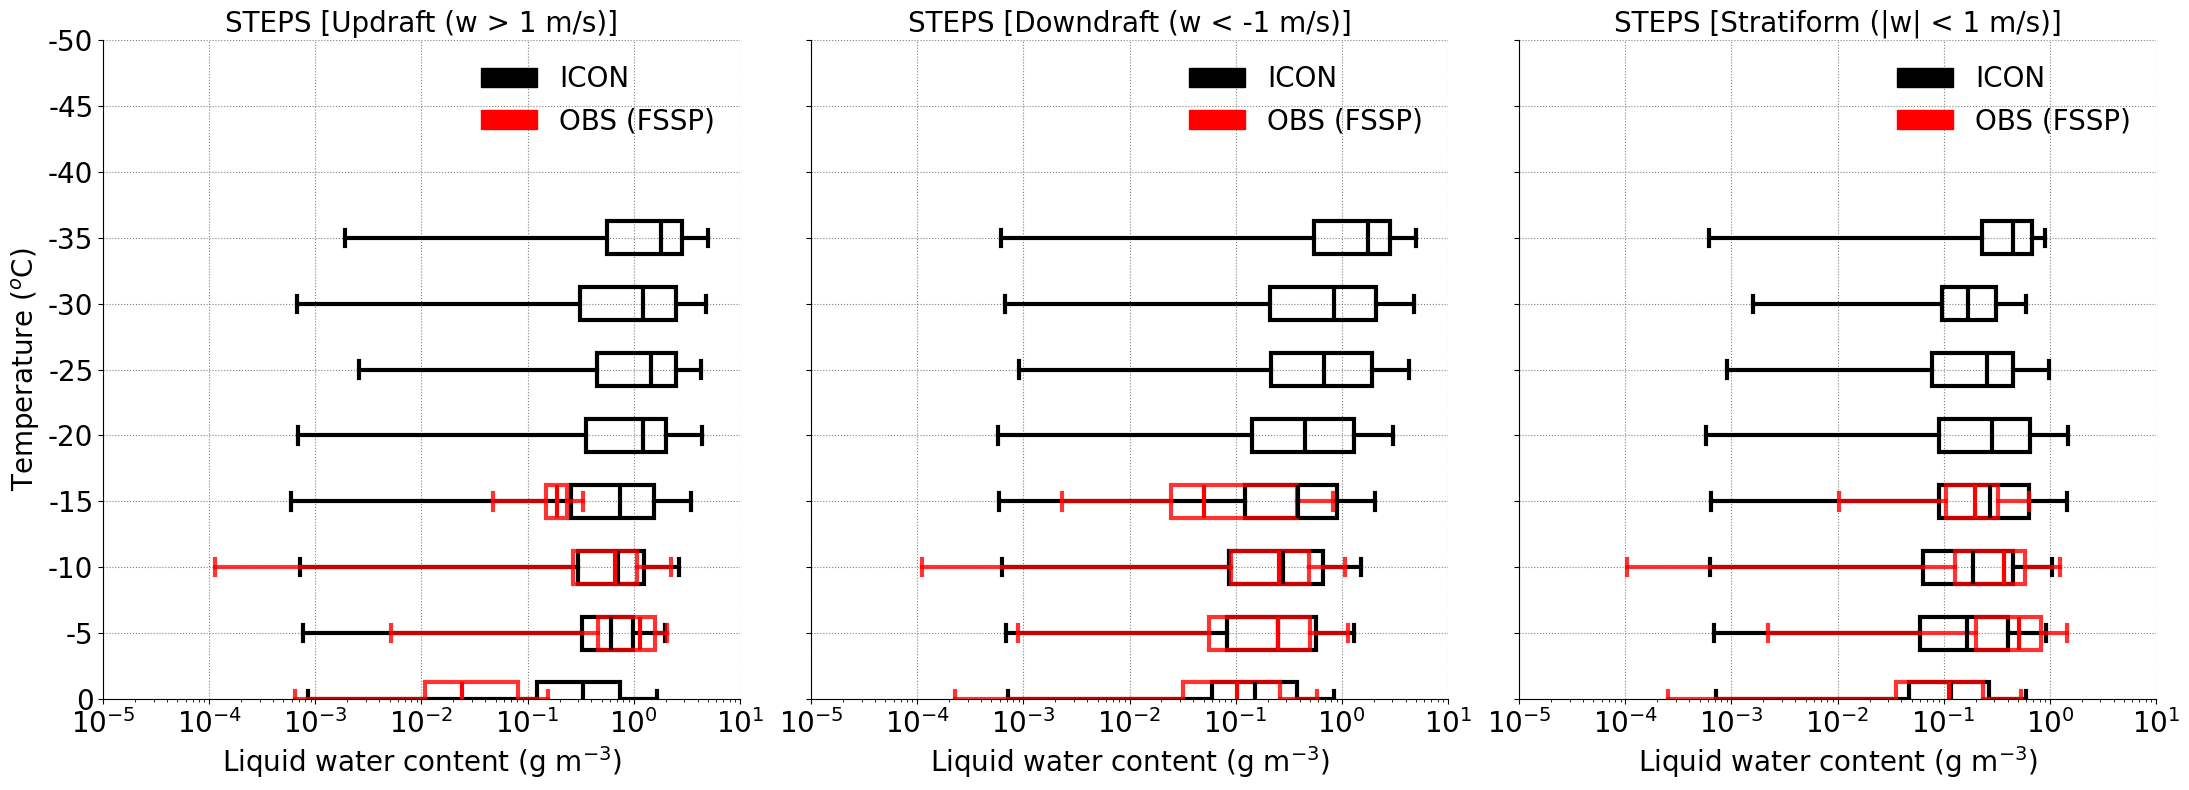

In [17]:

#temp_fssp_bin = np.arange(df_t28_obs['tempc'].min() - 2, df_t28_obs['tempc'].max() + 2, 3)  # Adjust bin range

temp_fssp_bin = np.arange(-50., 20., 5.)
temp_fssp_bin = np.sort(temp_fssp_bin)
df_t28_obs['temp_fssp_bin'] = np.digitize(df_t28_obs['tempc'], bins=temp_fssp_bin, right=False)

bin_edges = np.concatenate([temp_fssp_bin - 2, [temp_fssp_bin[-1] + 2]])  # Adjust to cover the temperature range
df_t28_obs['temp_bin'] = bin_edges[df_t28_obs['temp_fssp_bin']]


### LWC
df_lwc_up_fssp = df_t28_obs[['lwc_up', 'temp_bin']].dropna()
df_lwc_dn_fssp = df_t28_obs[['lwc_dn', 'temp_bin']].dropna()
df_lwc_st_fssp = df_t28_obs[['lwc_st', 'temp_bin']].dropna()

df_lwc_up_fssp = df_lwc_up_fssp.dropna(subset=['temp_bin'])
df_lwc_dn_fssp = df_lwc_dn_fssp.dropna(subset=['temp_bin'])
df_lwc_st_fssp = df_lwc_st_fssp.dropna(subset=['temp_bin'])

lwc_fssp_up_by_bin = [df_lwc_up_fssp[df_lwc_up_fssp['temp_bin'] == temp]['lwc_up'].values for temp in bin_edges]
lwc_fssp_dn_by_bin = [df_lwc_dn_fssp[df_lwc_dn_fssp['temp_bin'] == temp]['lwc_dn'].values for temp in bin_edges]
lwc_fssp_st_by_bin = [df_lwc_st_fssp[df_lwc_st_fssp['temp_bin'] == temp]['lwc_st'].values for temp in bin_edges]

#### Total number concentrations
df_tot_conc_up_fssp = df_t28_obs[['tot_conc_up', 'temp_bin']].dropna()
df_tot_conc_dn_fssp = df_t28_obs[['tot_conc_dn', 'temp_bin']].dropna()
df_tot_conc_st_fssp = df_t28_obs[['tot_conc_st', 'temp_bin']].dropna()

df_tot_conc_up_fssp = df_tot_conc_up_fssp.dropna(subset=['temp_bin'])
df_tot_conc_dn_fssp = df_tot_conc_dn_fssp.dropna(subset=['temp_bin'])
df_tot_conc_st_fssp = df_tot_conc_st_fssp.dropna(subset=['temp_bin'])

tot_conc_fssp_up_by_bin = [df_tot_conc_up_fssp[df_tot_conc_up_fssp['temp_bin'] == temp]['tot_conc_up'].values for temp in bin_edges]
tot_conc_fssp_dn_by_bin = [df_tot_conc_dn_fssp[df_tot_conc_dn_fssp['temp_bin'] == temp]['tot_conc_dn'].values for temp in bin_edges]
tot_conc_fssp_st_by_bin = [df_tot_conc_st_fssp[df_tot_conc_st_fssp['temp_bin'] == temp]['tot_conc_st'].values for temp in bin_edges]


fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['STEPS [Updraft (w > 1 m/s)]', 'STEPS [Downdraft (w < -1 m/s)]', 'STEPS [Stratiform (|w| < 1 m/s)]']

fontsize = 20;
linewidth = 3;
width=2.5
alpha1=1.0
alpha2=0.8
for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    # Plot ICON line if applicable (replace with actual values)
    if i == 0:
        #ax.plot(lwc_up_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(lwc_4sip_up_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
            widths=width,
            boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
            medianprops=dict(color='black', linewidth=linewidth),
            whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
            capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
            showfliers=False)
        ax.boxplot(lwc_fssp_up_by_bin[:-1], positions=temp_fssp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
        
    elif i == 1:
        #ax.plot(lwc_dn_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(lwc_4sip_dn_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
            widths=width,
            boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
            medianprops=dict(color='black', linewidth=linewidth),
            whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
            capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
            showfliers=False)
        ax.boxplot(lwc_fssp_dn_by_bin[:-1], positions=temp_fssp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
    elif i == 2:
        #ax.plot(lwc_st_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(lwc_4sip_st_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
            widths=width,
            boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
            medianprops=dict(color='black', linewidth=linewidth),
            whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
            capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
            showfliers=False)
        ax.boxplot(lwc_fssp_st_by_bin[:-1], positions=temp_fssp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)

    ax.set_xscale('log')
    ax.set_xlim(1.e-5, 1.e1)
    ax.set_xticklabels([1.e-5, 1.e-4, 1.e-3, 1.e-2, 1.e-1, 1.e0, 1.e1], fontsize=fontsize)
    ax.set_ylim(0, -50)
    #ax.set_yticklabels([20, 10, 0, -10, -20, -30, -40], fontsize=fontsize)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Liquid water content (g m$^{-3}$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=1.0)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    obs_patch1 = mpatches.Patch(color='black', label='ICON')
    obs_patch2 = mpatches.Patch(color='red', label='OBS (FSSP)')

    ax.legend(handles=handles + [obs_patch1,obs_patch2], frameon=False, loc='best', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([0, -5, -10, -15, -20, -25, -30, -35, -40, -45, -50])
axes[0].set_yticklabels(['0', '-5', '-10', '-15', '-20', '-25', '-30', '-35', '-40',  '-45', '-50'], fontsize=fontsize)

#axes[0].set_yticks([20, 15, 10, 5, 0, -5, -10, -15, -20, -25, -30, -35, -40, -45, -50])
#axes[0].set_yticklabels(['20', '15', '10', '5', '0', '-5', '-10', '-15', '-20', '-25', '-30', '-35', '-40',  '-45', '-50'], fontsize=fontsize)

plt.tight_layout()
plt.show()

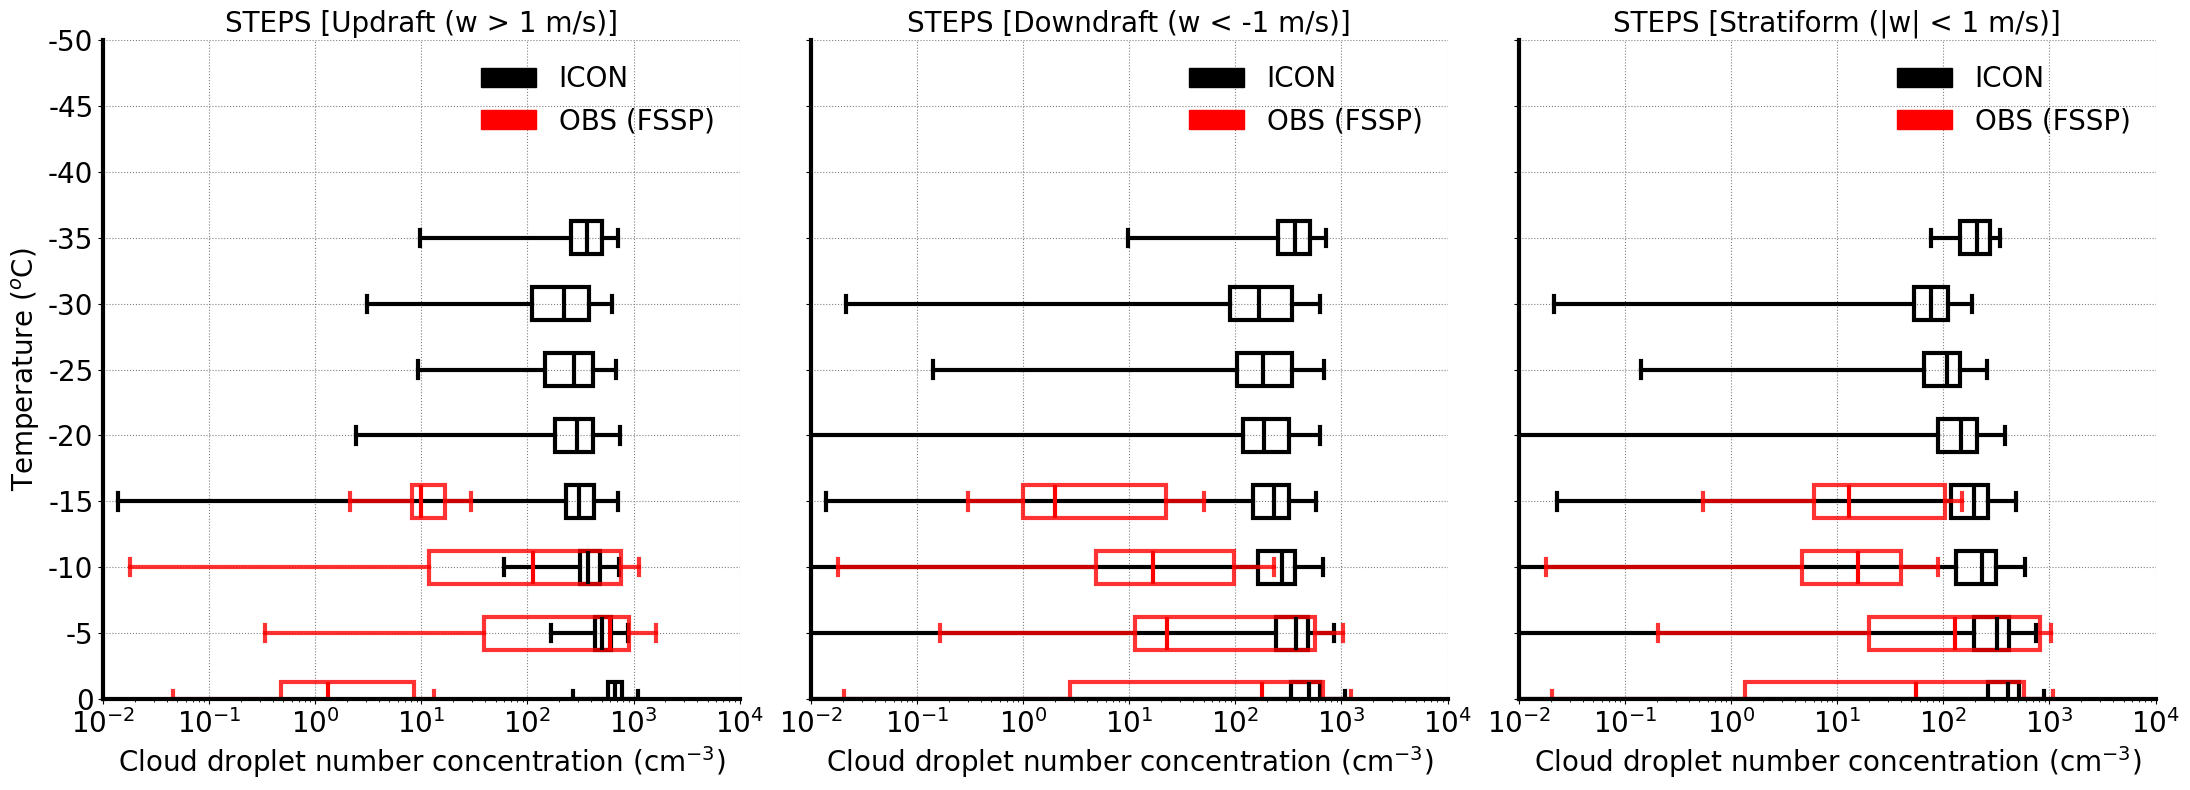

In [273]:


#temp_fssp_bin = np.arange(df_t28_obs['tempc'].min() - 2, df_t28_obs['tempc'].max() + 2, 5)  # Adjust bin range

temp_fssp_bin = np.arange(-50., 20., 5.)
temp_fssp_bin = np.sort(temp_fssp_bin)

df_t28_obs['temp_fssp_bin'] = np.digitize(df_t28_obs['tempc'], bins=temp_fssp_bin, right=False)

bin_edges = np.concatenate([temp_fssp_bin - 2, [temp_fssp_bin[-1] + 2]])  # Adjust to cover the temperature range
df_t28_obs['temp_bin'] = bin_edges[df_t28_obs['temp_fssp_bin']]


### LWC
df_lwc_up_fssp = df_t28_obs[['lwc_up', 'temp_bin']].dropna()
df_lwc_dn_fssp = df_t28_obs[['lwc_dn', 'temp_bin']].dropna()
df_lwc_st_fssp = df_t28_obs[['lwc_st', 'temp_bin']].dropna()

df_lwc_up_fssp = df_lwc_up_fssp.dropna(subset=['temp_bin'])
df_lwc_dn_fssp = df_lwc_dn_fssp.dropna(subset=['temp_bin'])
df_lwc_st_fssp = df_lwc_st_fssp.dropna(subset=['temp_bin'])

lwc_fssp_up_by_bin = [df_lwc_up_fssp[df_lwc_up_fssp['temp_bin'] == temp]['lwc_up'].values for temp in bin_edges]
lwc_fssp_dn_by_bin = [df_lwc_dn_fssp[df_lwc_dn_fssp['temp_bin'] == temp]['lwc_dn'].values for temp in bin_edges]
lwc_fssp_st_by_bin = [df_lwc_st_fssp[df_lwc_st_fssp['temp_bin'] == temp]['lwc_st'].values for temp in bin_edges]

#### Total number concentrations
df_tot_conc_up_fssp = df_t28_obs[['tot_conc_up', 'temp_bin']].dropna()
df_tot_conc_dn_fssp = df_t28_obs[['tot_conc_dn', 'temp_bin']].dropna()
df_tot_conc_st_fssp = df_t28_obs[['tot_conc_st', 'temp_bin']].dropna()

df_tot_conc_up_fssp = df_tot_conc_up_fssp.dropna(subset=['temp_bin'])
df_tot_conc_dn_fssp = df_tot_conc_dn_fssp.dropna(subset=['temp_bin'])
df_tot_conc_st_fssp = df_tot_conc_st_fssp.dropna(subset=['temp_bin'])

tot_conc_fssp_up_by_bin = [df_tot_conc_up_fssp[df_tot_conc_up_fssp['temp_bin'] == temp]['tot_conc_up'].values for temp in bin_edges]
tot_conc_fssp_dn_by_bin = [df_tot_conc_dn_fssp[df_tot_conc_dn_fssp['temp_bin'] == temp]['tot_conc_dn'].values for temp in bin_edges]
tot_conc_fssp_st_by_bin = [df_tot_conc_st_fssp[df_tot_conc_st_fssp['temp_bin'] == temp]['tot_conc_st'].values for temp in bin_edges]


fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['STEPS [Updraft (w > 1 m/s)]', 'STEPS [Downdraft (w < -1 m/s)]', 'STEPS [Stratiform (|w| < 1 m/s)]']

fontsize = 20;
linewidth = 3;
width=2.5
alpha1=1.0
alpha2=0.8
for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    # Plot ICON line if applicable (replace with actual values)
    if i == 0:
        #ax.plot(cdnc_up_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(cdnc_4sip_up_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
            widths=width,
            boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
            medianprops=dict(color='black', linewidth=linewidth),
            whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
            capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
            showfliers=False)
        ax.boxplot(tot_conc_fssp_up_by_bin[:-1], positions=temp_fssp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
        
    elif i == 1:
        #ax.plot(cdnc_dn_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(cdnc_4sip_dn_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
            widths=width,
            boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
            medianprops=dict(color='black', linewidth=linewidth),
            whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
            capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
            showfliers=False)
        ax.boxplot(tot_conc_fssp_dn_by_bin[:-1], positions=temp_fssp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)
    elif i == 2:
        #ax.plot(cdnc_st_sip, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(cdnc_4sip_st_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
            widths=width,
            boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
            medianprops=dict(color='black', linewidth=linewidth),
            whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
            capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
            showfliers=False)
        ax.boxplot(tot_conc_fssp_st_by_bin[:-1], positions=temp_fssp_bin, vert=False, patch_artist=True,
                   widths=width,
                   boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
                   medianprops=dict(color='red', linewidth=linewidth),  
                   whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
                   capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
                   showfliers=False)

    ax.set_xscale('log')
    ax.set_xlim(1.e-2, 1.e4)
    ax.set_xticklabels([1.e-2, 1.e0, 1.e2, 1.e4], fontsize=fontsize)
    ax.set_ylim(0, -50)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Cloud droplet number concentration (cm$^{-3}$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=1.0)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    obs_patch1 = mpatches.Patch(color='black', label='ICON')
    obs_patch2 = mpatches.Patch(color='red', label='OBS (FSSP)')

    ax.legend(handles=handles + [obs_patch1, obs_patch2], frameon=False, loc='best', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([0, -5, -10, -15, -20, -25, -30, -35, -40, -45, -50])
axes[0].set_yticklabels(['0', '-5', '-10', '-15', '-20', '-25', '-30', '-35', '-40', '-45', '-50'], fontsize=fontsize)

#axes[0].set_yticks([20, 15, 10, 5, 0, -5, -10, -15, -20, -25, -30, -35, -40, -45, -50])
#axes[0].set_yticklabels(['20', '15', '10', '5', '0', '-5', '-10', '-15', '-20', '-25', '-30', '-35', '-40',  '-45', '-50'], fontsize=fontsize)

plt.tight_layout()
plt.show()

In [265]:

import xarray as xr
import netCDF4

ds_air_obs = netCDF4.Dataset('/work/bk1415/b382718/output/steps/observations/aircraft_data/T28_STEPS2000_756.nc', 'r')
ds_2dc_obs = netCDF4.Dataset('/work/bk1415/b382718/output/steps/observations/aircraft_data/from_bansemer/20000620_001702_2DC.nc', 'r')


ds_air_new = {'temp_rm': ds_air_obs['TEMPERATURE_ROSEMOUNT_SENSOR'][:][:, 0],               # C
    'temp_rf': ds_air_obs.variables['TEMPERATURE_REVERSE_FLOW_SENSOR'][:][:, 0],            # C
    'air_den': ds_air_obs.variables['DENSITY_AIR'][:][:, 0],                                # kg/m3
    'fssp_lwc': ds_air_obs.variables['FSSP_LIQUID_WATER'][:][:, 0],                         # g/m3
    'fssp_diam': ds_air_obs.variables['FSSP_AVERAGE_DIAMETER'][:][:, 0],                    # µm
    'fssp_tot_conc': ds_air_obs.variables['FSSP_TOTAL_PARTICLE_CONCENTRATION'][:][:, 0],    # count/cm3
    'fssp_eq_diam': ds_air_obs.variables['FSSP_EQUIVALENT_DIAMETER'][:][:, 0],              # µm
    'fssp_qc': ds_air_obs.variables['FSSP_LIQUID_WATER_MIXING_RATIO'][:][:, 0],             # gperkg
    'w_vel': ds_air_obs.variables['UPDRAFT'][:][:, 0]                                       # m/s
}


time = ds_air_obs['Time'][:][:, 0]
#print(time)
# Convert ds_air_new to an xarray Dataset
ds_air_new = xr.Dataset(
    {key: ('time', value) for key, value in ds_air_new.items()},
    coords={'time': time})


ds_2dc_new = {
    'TAS' : ds_2dc_obs['TAS'],                        # m/s
    'NT100_2DC' : ds_2dc_obs['NT100'],                # per m3 
    'MND100_2DC' : ds_2dc_obs['MND100'],              # µm
    'MVD100_2DC' : ds_2dc_obs['MVD100'],              # µm
    'DMASS100_2DC' : ds_2dc_obs['DMASS100'],          # µm
    'IWC100_2DC' : ds_2dc_obs['IWC100'],              # g/m3
    'AREA100_2DC' : ds_2dc_obs['AREA100'],            # m
    'NT200_2DC' : ds_2dc_obs['NT200'],                # per m3 
    'MND200_2DC' : ds_2dc_obs['MND200'],
    'MVD200_2DC' : ds_2dc_obs['MVD200'],
    'DMASS200_2DC' : ds_2dc_obs['DMASS200'],
    'IWC200_2DC' : ds_2dc_obs['IWC200'],
    'AREA200_2DC' : ds_2dc_obs['AREA200'],
}

time = ds_2dc_obs['time'][:]

ds_2dc_new = xr.Dataset(
    {key: ('time', value) for key, value in ds_2dc_new.items()},
    coords={'time': time}
)

# Find common times between ds_2dc_new and ds_air_new
time_air = ds_air_new.time
time_2dc = ds_2dc_new.time
common_times = np.intersect1d(time_2dc, time_air)

ds_air_new = ds_air_new.sel(time=common_times)
ds_2dc_new = ds_2dc_new.sel(time=common_times)


w_thres = 1.

ds_2dc_new['NT200_2DC_perl'] = 1.e-3*ds_2dc_new['NT200_2DC']

# NI200
filt_inc200_2dc_up_cond = (ds_2dc_new.NT200_2DC_perl > 1.e-9) & (ds_air_new.w_vel > w_thres)
filt_inc200_2dc_dn_cond = (ds_2dc_new.NT200_2DC_perl > 1.e-9) & (ds_air_new.w_vel < -1*w_thres)
filt_inc200_2dc_st_cond = (ds_2dc_new.NT200_2DC_perl > 1.e-9) & (np.abs(ds_air_new.w_vel) < w_thres)

inc200_2dc_up = np.where(filt_inc200_2dc_up_cond, ds_2dc_new.NT200_2DC_perl, np.nan)
inc200_2dc_dn = np.where(filt_inc200_2dc_dn_cond, ds_2dc_new.NT200_2DC_perl, np.nan)
inc200_2dc_st = np.where(filt_inc200_2dc_st_cond, ds_2dc_new.NT200_2DC_perl, np.nan)

# IWC
filt_iwc200_2dc_up_cond = (ds_2dc_new.IWC200_2DC > 1.e-9) & (ds_air_new.w_vel > w_thres)
filt_iwc200_2dc_dn_cond = (ds_2dc_new.IWC200_2DC > 1.e-9) & (ds_air_new.w_vel < -1*w_thres)
filt_iwc200_2dc_st_cond = (ds_2dc_new.IWC200_2DC > 1.e-9) & (np.abs(ds_air_new.w_vel) < w_thres)

iwc200_2dc_up = np.where(filt_iwc200_2dc_up_cond, ds_2dc_new.IWC200_2DC, np.nan)
iwc200_2dc_dn = np.where(filt_iwc200_2dc_dn_cond, ds_2dc_new.IWC200_2DC, np.nan)
iwc200_2dc_st = np.where(filt_iwc200_2dc_st_cond, ds_2dc_new.IWC200_2DC, np.nan)


# Create a pandas dataframe
df_2dc_obs = pd.DataFrame({
    'tempc': ds_air_new['temp_rm'],
    'w_vel': ds_air_new['w_vel'],
    'air_den':ds_air_new['air_den'],
    'NT200':ds_2dc_new['NT200_2DC'],
    'IWC200':ds_2dc_new['IWC200_2DC'], 
    'inc200_2dc_up':inc200_2dc_up,
    'inc200_2dc_dn':inc200_2dc_dn,
    'inc200_2dc_st':inc200_2dc_st,
    'iwc200_2dc_up':iwc200_2dc_up,
    'iwc200_2dc_dn':iwc200_2dc_dn,
    'iwc200_2dc_st':iwc200_2dc_st,
})


#print(ni200_2dc_up)
#plt.plot(1.e-3*ds_2dc_new.NT200_2DC, ds_air_new.temp_rm)

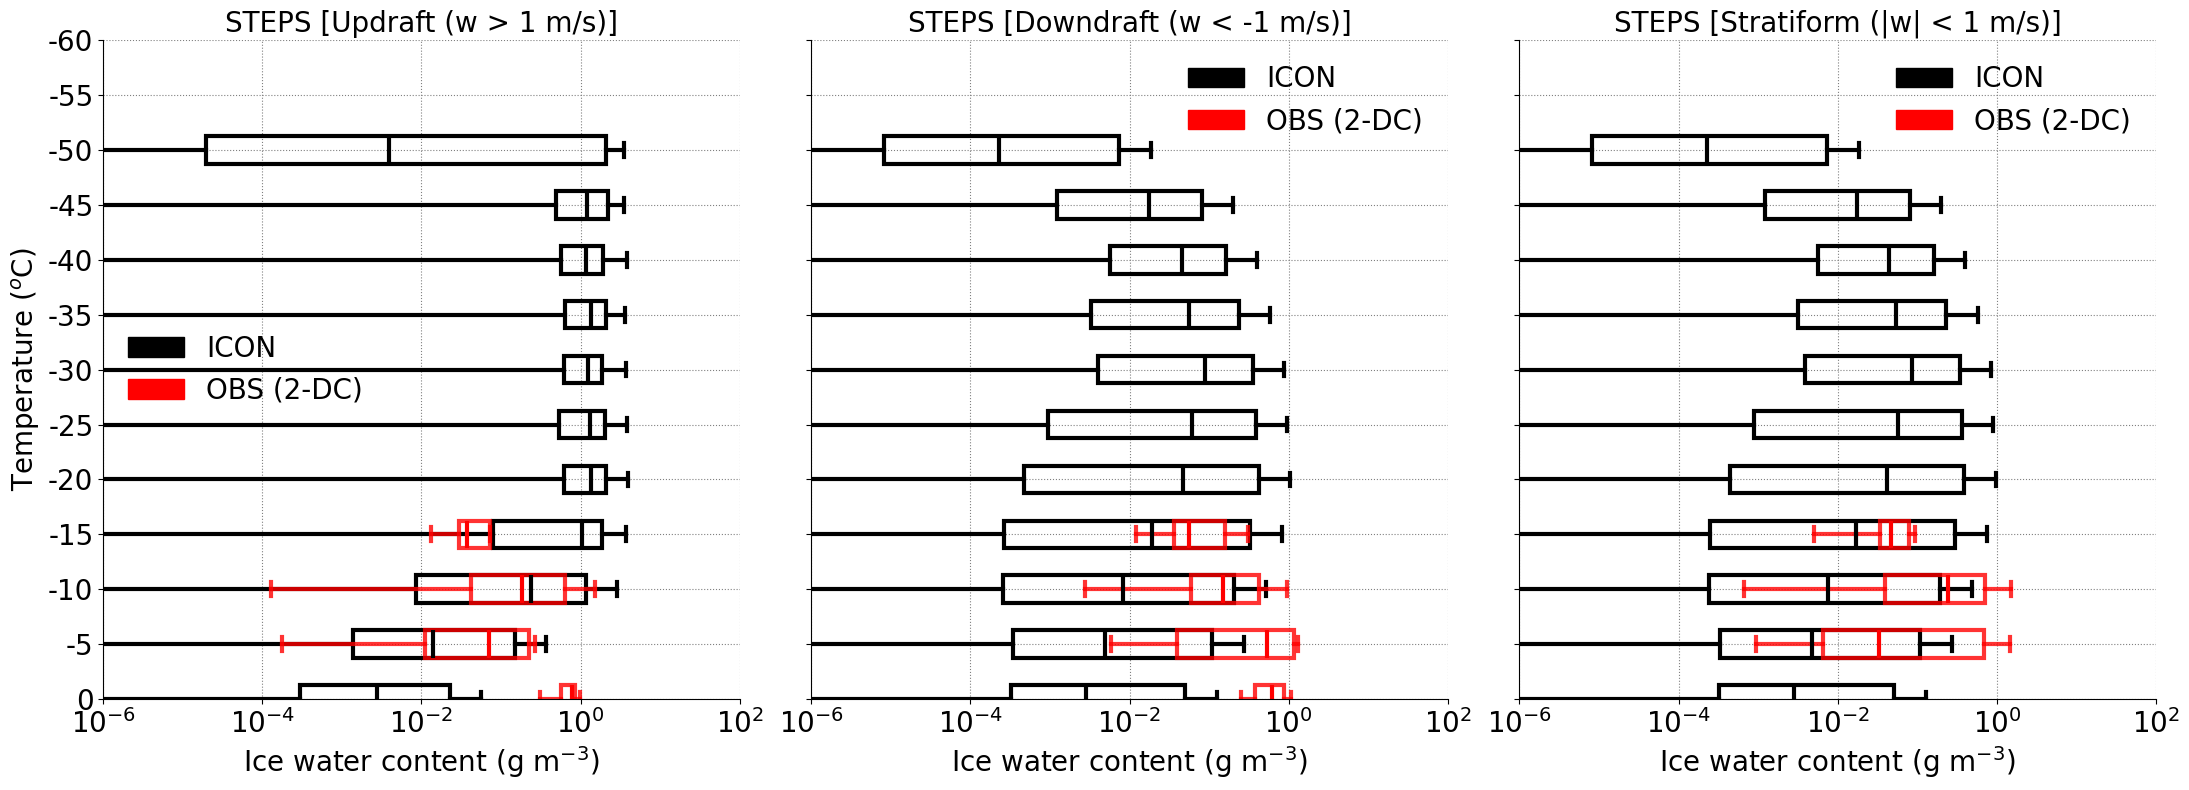

In [256]:
temp_2dc_bin = np.arange(-50., 20., 5.)
temp_2dc_bin = np.sort(temp_2dc_bin)
#temp_2dc_bin = (df_2dc_obs['tempc'].min() - 2, df_2dc_obs['tempc'].max() + 2, 3)
#temp_2dc_bin = np.sort(temp_2dc_bin)
df_2dc_obs['temp_2dc_bin'] = np.digitize(df_2dc_obs['tempc'], bins=temp_2dc_bin, right=False)

bin_edges = np.concatenate([temp_2dc_bin - 2, [temp_2dc_bin[-1] + 2]])  # Adjust to cover the temperature range
df_2dc_obs['temp_bin'] = bin_edges[df_2dc_obs['temp_2dc_bin']]


### LWC
df_iwc200_up_2dc = df_2dc_obs[['iwc200_2dc_up', 'temp_bin']].dropna()
df_iwc200_dn_2dc = df_2dc_obs[['iwc200_2dc_dn', 'temp_bin']].dropna()
df_iwc200_st_2dc = df_2dc_obs[['iwc200_2dc_st', 'temp_bin']].dropna()

df_iwc200_up_2dc = df_iwc200_up_2dc.dropna(subset=['temp_bin'])
df_iwc200_dn_2dc = df_iwc200_dn_2dc.dropna(subset=['temp_bin'])
df_iwc200_st_2dc = df_iwc200_st_2dc.dropna(subset=['temp_bin'])

iwc200_2dc_up_by_bin = [df_iwc200_up_2dc[df_iwc200_up_2dc['temp_bin'] == temp]['iwc200_2dc_up'].values for temp in bin_edges]
iwc200_2dc_dn_by_bin = [df_iwc200_dn_2dc[df_iwc200_dn_2dc['temp_bin'] == temp]['iwc200_2dc_dn'].values for temp in bin_edges]
iwc200_2dc_st_by_bin = [df_iwc200_st_2dc[df_iwc200_st_2dc['temp_bin'] == temp]['iwc200_2dc_st'].values for temp in bin_edges]


fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['STEPS [Updraft (w > 1 m/s)]', 'STEPS [Downdraft (w < -1 m/s)]', 'STEPS [Stratiform (|w| < 1 m/s)]']

fontsize = 20;
linewidth = 3;
width=2.5
alpha1=1.0
alpha2=0.8
for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    # Plot ICON line if applicable (replace with actual values)
    if i == 0:
        #ax.plot(iwc200_2dc_up_by_bin, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(iwc_4sip_up_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
            widths=width,
            boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
            medianprops=dict(color='black', linewidth=linewidth),
            whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
            capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
            showfliers=False)
        ax.boxplot(iwc200_2dc_up_by_bin[:-1], positions=temp_2dc_bin, vert=False, patch_artist=True,
            widths=width,
            boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
            medianprops=dict(color='red', linewidth=linewidth),  
            whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
            capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
            showfliers=False)
        
        
    elif i == 1:
        #ax.plot(iwc200_2dc_dn_by_bin, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(iwc_4sip_dn_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
            widths=width,
            boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
            medianprops=dict(color='black', linewidth=linewidth),
            whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
            capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
            showfliers=False)
        ax.boxplot(iwc200_2dc_dn_by_bin[:-1], positions=temp_2dc_bin, vert=False, patch_artist=True,
            widths=width,
            boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
            medianprops=dict(color='red', linewidth=linewidth),  
            whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
            capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
            showfliers=False)
        
    elif i == 2:
        #ax.plot(iwc200_2dc_st_by_bin, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(iwc_4sip_st_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
            widths=width,
            boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
            medianprops=dict(color='black', linewidth=linewidth),
            whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
            capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
            showfliers=False)
        ax.boxplot(iwc200_2dc_st_by_bin[:-1], positions=temp_2dc_bin, vert=False, patch_artist=True,
            widths=width,
            boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
            medianprops=dict(color='red', linewidth=linewidth),  
            whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
            capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
            showfliers=False)
        

    ax.set_xscale('log')
    ax.set_xlim(1.e-6, 1.e2)
    #ax.set_xticklabels([1.e-2, 1.e0, 1.e2, 1.e4], fontsize=fontsize)
    ax.set_ylim(0, -50)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Ice water content (g m$^{-3}$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=1.0)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    obs_patch1 = mpatches.Patch(color='black', label='ICON')
    obs_patch2 = mpatches.Patch(color='red', label='OBS (2-DC)')

    ax.legend(handles=handles + [obs_patch1, obs_patch2], frameon=False, loc='best', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([0, -5, -10, -15, -20, -25, -30, -35, -40, -45, -50, -55, -60])
axes[0].set_yticklabels(['0', '-5', '-10', '-15', '-20', '-25', '-30', '-35', '-40', '-45', '-50', '-55', '-60'], fontsize=fontsize)

#axes[0].set_yticks([20, 15, 10, 5, 0, -5, -10, -15, -20, -25, -30, -35, -40, -45, -50])
#axes[0].set_yticklabels(['20', '15', '10', '5', '0', '-5', '-10', '-15', '-20', '-25', '-30', '-35', '-40',  '-45', '-50'], fontsize=fontsize)

plt.tight_layout()
plt.show()

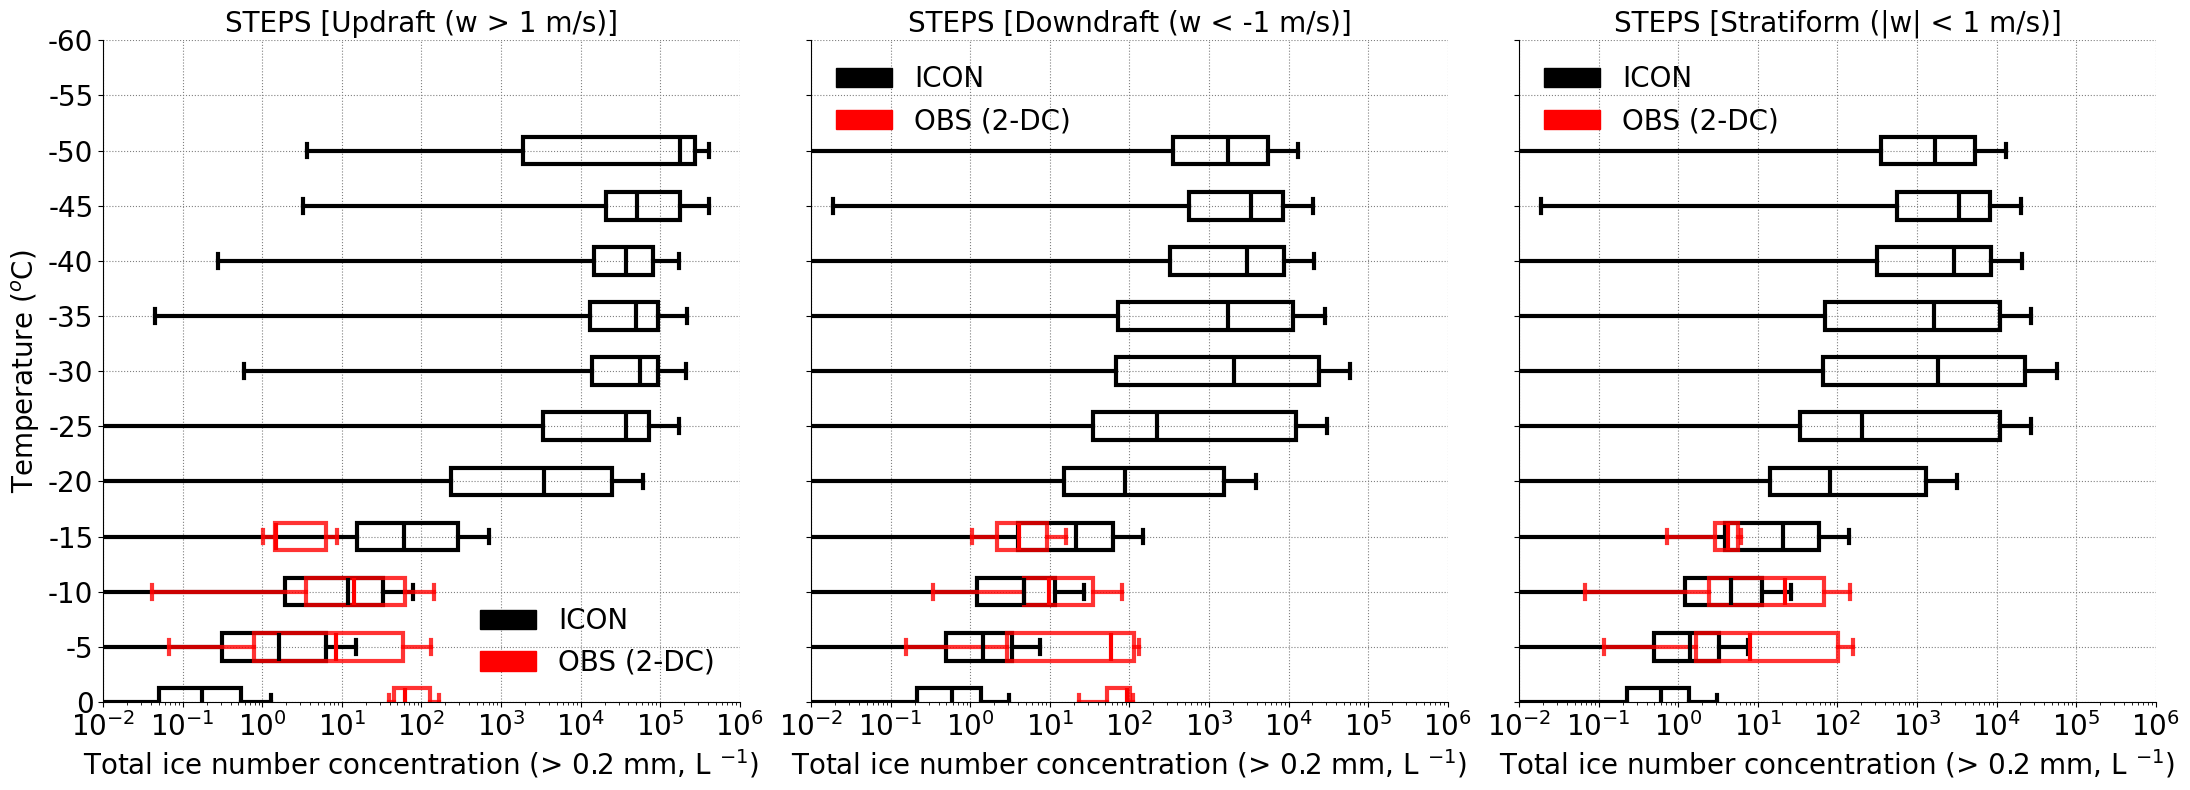

In [270]:
temp_2dc_bin = np.arange(-50., 20., 5.)
temp_2dc_bin = np.sort(temp_2dc_bin)
#temp_2dc_bin = (df_2dc_obs['tempc'].min() - 2, df_2dc_obs['tempc'].max() + 2, 3)
#temp_2dc_bin = np.sort(temp_2dc_bin)
df_2dc_obs['temp_2dc_bin'] = np.digitize(df_2dc_obs['tempc'], bins=temp_2dc_bin, right=False)

bin_edges = np.concatenate([temp_2dc_bin - 2, [temp_2dc_bin[-1] + 2]])  # Adjust to cover the temperature range
df_2dc_obs['temp_bin'] = bin_edges[df_2dc_obs['temp_2dc_bin']]


### LWC
df_inc200_up_2dc = df_2dc_obs[['inc200_2dc_up', 'temp_bin']].dropna()
df_inc200_dn_2dc = df_2dc_obs[['inc200_2dc_dn', 'temp_bin']].dropna()
df_inc200_st_2dc = df_2dc_obs[['inc200_2dc_st', 'temp_bin']].dropna()

df_inc200_up_2dc = df_inc200_up_2dc.dropna(subset=['temp_bin'])
df_inc200_dn_2dc = df_inc200_dn_2dc.dropna(subset=['temp_bin'])
df_inc200_st_2dc = df_inc200_st_2dc.dropna(subset=['temp_bin'])

inc200_2dc_up_by_bin = [df_inc200_up_2dc[df_inc200_up_2dc['temp_bin'] == temp]['inc200_2dc_up'].values for temp in bin_edges]
inc200_2dc_dn_by_bin = [df_inc200_dn_2dc[df_inc200_dn_2dc['temp_bin'] == temp]['inc200_2dc_dn'].values for temp in bin_edges]
inc200_2dc_st_by_bin = [df_inc200_st_2dc[df_inc200_st_2dc['temp_bin'] == temp]['inc200_2dc_st'].values for temp in bin_edges]


fig, axes = plt.subplots(1, 3, figsize=(22, 8), sharey=True)
plot_titles = ['STEPS [Updraft (w > 1 m/s)]', 'STEPS [Downdraft (w < -1 m/s)]', 'STEPS [Stratiform (|w| < 1 m/s)]']

fontsize = 20;
linewidth = 3;
width=2.5
alpha1=1.0
alpha2=0.8
for i, ax in enumerate(axes):
    #temp_bins = temp_bins_list[i]
    #data_by_bin = data_list[i]

    # Plot ICON line if applicable (replace with actual values)
    if i == 0:
        #ax.plot(iwc200_2dc_up_by_bin, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(inc_4sip_up_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
            widths=width,
            boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
            medianprops=dict(color='black', linewidth=linewidth),
            whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
            capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
            showfliers=False)
        ax.boxplot(inc200_2dc_up_by_bin[:-1], positions=temp_2dc_bin, vert=False, patch_artist=True,
            widths=width,
            boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
            medianprops=dict(color='red', linewidth=linewidth),  
            whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
            capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
            showfliers=False)
        
        
    elif i == 1:
        #ax.plot(iwc200_2dc_dn_by_bin, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(inc_4sip_dn_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
            widths=width,
            boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
            medianprops=dict(color='black', linewidth=linewidth),
            whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
            capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
            showfliers=False)
        ax.boxplot(inc200_2dc_dn_by_bin[:-1], positions=temp_2dc_bin, vert=False, patch_artist=True,
            widths=width,
            boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
            medianprops=dict(color='red', linewidth=linewidth),  
            whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
            capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
            showfliers=False)
        
    elif i == 2:
        #ax.plot(iwc200_2dc_st_by_bin, tempc_sip, 'k-', linewidth=linewidth+2, label='ICON')
        ax.boxplot(inc_4sip_st_by_bin[:-1], positions=tempc_bin, vert=False, patch_artist=True,
            widths=width,
            boxprops=dict(facecolor='none', edgecolor='black', linewidth=linewidth, alpha=alpha1),
            medianprops=dict(color='black', linewidth=linewidth),
            whiskerprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
            capprops=dict(linewidth=linewidth, color='black', alpha=alpha1),
            showfliers=False)
        ax.boxplot(inc200_2dc_st_by_bin[:-1], positions=temp_2dc_bin, vert=False, patch_artist=True,
            widths=width,
            boxprops=dict(facecolor='none', edgecolor='red', linewidth=linewidth, alpha=alpha2),  
            medianprops=dict(color='red', linewidth=linewidth),  
            whiskerprops=dict(linewidth=linewidth, color='red', alpha=alpha2),  
            capprops=dict(linewidth=linewidth, color='red', alpha=alpha2),
            showfliers=False)
        

    ax.set_xscale('log')
    ax.set_xlim(1.e-2, 1.e6)
    #ax.set_xticklabels([1.e-2, 1.e0, 1.e2, 1.e4], fontsize=fontsize)
    ax.set_ylim(0, -50)
    ax.set_title(plot_titles[i], fontsize=fontsize)
    ax.set_xlabel('Total ice number concentration (> 0.2 mm, L $^{-1}$)', fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.grid(True, linestyle=':', color='grey',alpha=1.0)

    # Combine both ICON line and boxplot legend
    handles, labels = ax.get_legend_handles_labels()

    obs_patch1 = mpatches.Patch(color='black', label='ICON')
    obs_patch2 = mpatches.Patch(color='red', label='OBS (2-DC)')

    ax.legend(handles=handles + [obs_patch1, obs_patch2], frameon=False, loc='best', fontsize=fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[0].set_ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
axes[0].set_yticks([0, -5, -10, -15, -20, -25, -30, -35, -40, -45, -50, -55, -60])
axes[0].set_yticklabels(['0', '-5', '-10', '-15', '-20', '-25', '-30', '-35', '-40', '-45', '-50', '-55', '-60'], fontsize=fontsize)

#axes[0].set_yticks([20, 15, 10, 5, 0, -5, -10, -15, -20, -25, -30, -35, -40, -45, -50])
#axes[0].set_yticklabels(['20', '15', '10', '5', '0', '-5', '-10', '-15', '-20', '-25', '-30', '-35', '-40',  '-45', '-50'], fontsize=fontsize)

plt.tight_layout()
plt.show()

In [19]:

file_path = '/work/bk1415/b382718/output/steps/observations/aircraft_data/raw/yr2000/f756/f756_2dc.raw'

# Attempt to read the raw file as a generic binary file
raw_data = np.fromfile(file_path, dtype=np.uint8)  # or dtype=np.uint16, np.int16, etc.

# Inspect the first few bytes
print(raw_data[:3])

[  0   0 112]


In [20]:

def calc_dewpoint(tempc, rh):
    dewpoint = tempc - ((100. - rh)/5.)
    return dewpoint


def calc_tdew(t, rh):        # Magnus-Tetens approximation
    a = 17.27; b = 237.7;
    alpha = (a*t/(b+t)) + np.log(rh/100)
    td = b*alpha/(a-alpha)
    return td
    
def calc_vir_temp(tc, q):
    #virt_tempk_wk = t/(1. - (ev/p)*(1-0.622))
    temp = tc + (1-0.622*q)
    return temp
    
def calculate_lcl(pressure, temperature, dewpoint):
    l = np.argmin(np.abs(temperature - dewpoint))
    return pressure[l], temperature[l]

def calc_lcl(t, td):
    lcl = td + 125.*(t-td)
    return lcl
    
def e_sat_hpa(tc):
    e_sat_pa = 6.112*np.exp((17.67*tc)/(tc+243.5))
    return e_sat_pa

def calc_parcel_temp(pres, ht, q_sat, tk_lcl):
    grav = 9.8  # acceleration due to gravity [m/s^2]
    eps = 0.622  # ratio of the gas constants for water vapor and dry air
    Rd = 287.  # specific gas constant for dry air [J/(kg*K)]
    cp = 1005.  # specific heat capacity at constant pressure for dry air [J/(kg*K)]
    lv = 2.5e6  # latent heat of vaporization [J/kg]
    Rv = 461.  # specific gas constant for water vapor [J/(kg*K)]

    tk_parcel = np.zeros(len(ht))  
    del_t_par = np.zeros(len(ht))  

    tk_parcel[0] = tk_lcl + 273.15 
    
    for i in range(1, len(ht)):
        dht = ht[i] - ht[i - 1]  
        qs = q_sat[i]  
        term_a = 1. + lv * qs / (Rd * tk_parcel[i - 1])
        term_b = (lv ** 2.) * eps * qs
        term_c = Rd * (tk_parcel[i - 1]) ** 2.
        
        del_t_par[i] = grav * term_a / (cp + (term_b / term_c))

        tk_parcel[i] = tk_parcel[i - 1] - del_t_par[i] * dht
        
    tempc = tk_parcel - 273.15
    return tempc

import numpy as np



def calc_cape(pres, t_env, t_par, tv_env, tv_par):
    """
    Calculate Convective Available Potential Energy (CAPE).
    
    Parameters:
        pres (array): Pressure levels (hPa or Pa).
        t_env (array): Environmental temperature (°C).
        t_par (array): Parcel temperature (°C).
        tv_env (array): Environmental virtual temperature (°C).
        tv_par (array): Parcel virtual temperature (°C).
    
    Returns:
        cape (float): CAPE value (J/kg).
    """
    Rd = 287.0  # gas constant for dry air (J/kg/K)
    
    # Convert temperatures to Kelvin
    tk_env = t_env + 273.15
    tk_v_env = tv_env + 273.15
    tk_par = t_par + 273.15
    tk_v_par = tv_par + 273.15
    
    cape = 0.0
    
    # Loop through pressure levels
    for i in range(1, len(pres)):
        # Check if parcel is warmer than the environment
        if tk_v_par[i] > tk_v_env[i]:
            # Calculate logarithmic pressure difference
            dlnp = np.log(pres[i-1] / pres[i])
            cape = cape + Rd * (tk_v_par[i] - tk_v_env[i]) * dlnp
    return cape
        

In [48]:
ds_4sip.time

<xarray.DataArray 'time' (time: 29)>
array(['2000-06-19T12:00:00.000000000', '2000-06-19T12:30:00.000000000',
       '2000-06-19T13:00:00.000000000', '2000-06-19T13:30:00.000000000',
       '2000-06-19T14:00:00.000000000', '2000-06-19T14:30:00.000000000',
       '2000-06-19T15:00:00.000000000', '2000-06-19T15:30:00.000000000',
       '2000-06-19T16:00:00.000000000', '2000-06-19T16:30:00.000000000',
       '2000-06-19T17:00:00.000000000', '2000-06-19T17:30:00.000000000',
       '2000-06-19T18:00:00.000000000', '2000-06-19T18:30:00.000000000',
       '2000-06-19T19:00:00.000000000', '2000-06-19T19:30:00.000000000',
       '2000-06-19T20:00:00.000000000', '2000-06-19T20:30:00.000000000',
       '2000-06-19T21:00:00.000000000', '2000-06-19T21:30:00.000000000',
       '2000-06-19T22:00:00.000000000', '2000-06-19T22:30:00.000000000',
       '2000-06-19T23:00:00.000000000', '2000-06-19T23:30:00.000000000',
       '2000-06-20T00:00:00.000000000', '2000-06-20T00:30:00.000000000',
       '2000-06-20T01:00:00.000000000', '2000-06-20T01:30:00.000000000',
       '2000-06-20T02:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2000-06-19T12:00:00 ... 2000-06-20T02:00:00
Attributes:
    standard_name:  time
    axis:           T

CAPE ::  1134.2228793854447


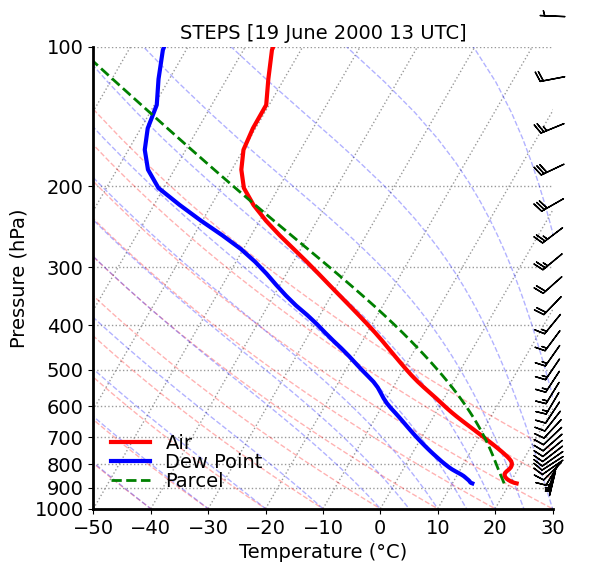

In [21]:

ds_skewt = ds_4sip.sel(time=ds_4sip.time[6])

tempc = ds_skewt.temp-273.15 #.values
pres_pa = ds_skewt.pres #.values
ht_m = ds_skewt.z_mc
rel_hum = ds_skewt.rh #.values
u_wind = ds_skewt.u
v_wind = ds_skewt.v
q_vap = ds_skewt.qv

   
temp_dew = calc_dewpoint(tempc, rel_hum)
#temp_dew = calc_tdew(tempc, rel_hum)

avg_tempc = tempc.mean(dim=('ncells')).values
avg_dewtempc = temp_dew.mean(dim=('ncells')).values
avg_pres = 0.01*pres_pa.mean(dim=('ncells')).values
avg_ht = ht_m.mean(dim=('ncells')).values
avg_rh = rel_hum.mean(dim=('ncells')).values
avg_qv = q_vap.mean(dim=('ncells')).values

avg_u = u_wind.mean(dim=('ncells')).values
avg_v = v_wind.mean(dim=('ncells')).values

avg_tempc = avg_tempc[::-1]
avg_dewtempc = avg_dewtempc[::-1]
avg_pres = avg_pres[::-1]
avg_ht = avg_ht[::-1]
avg_rh = avg_rh[::-1]
avg_u = avg_u[::-1]
avg_v = avg_v[::-1]
avg_qv = avg_qv[::-1]

#----- Calculate parcel properties
e_sat = e_sat_hpa(avg_tempc)
q_sat = 0.622*e_sat/(avg_pres-e_sat)

lcl_pressure, lcl_temp = calculate_lcl(avg_pres, avg_tempc, avg_dewtempc)
#lcl_temp = calc_lcl(avg_tempc[0], avg_dewtempc)
parcel_temp = calc_parcel_temp(avg_pres, avg_ht, q_sat, lcl_temp)
Tv_env = calc_vir_temp(avg_tempc, avg_qv)
Tv_parcel = calc_vir_temp(parcel_temp, q_sat)
parcel_cape = calc_cape(avg_pres, avg_tempc, parcel_temp, Tv_env, Tv_parcel)
print('CAPE :: ',parcel_cape)
#------

# Create the Skew-T plot
fontsize=14;
lnwdth=3;
alpha=0.3;

fig = plt.figure(figsize=(8, 6))
skew = SkewT(fig)

# Plot temperature and dew point on the Skew-T
skew.plot(avg_pres, avg_tempc, 'r-', label='Air', linewidth=lnwdth)
#skew.plot(avg_pres, calc_dewpoint(avg_tempc, avg_rh), 'b-.', label='Dew Point', linewidth=lnwdth)
skew.plot(avg_pres, avg_dewtempc, 'b-', label='Dew Point', linewidth=lnwdth)
skew.plot(avg_pres, parcel_temp, 'g--', label='Parcel', linewidth=lnwdth-1)
# Add wind barbs 
if 'u' in ds_skewt and 'v' in ds_skewt:
    u_wind = avg_u  # Zonal wind component
    v_wind = avg_v  # Meridional wind component
    skew.plot_barbs(avg_pres[::2], u_wind[::2], v_wind[::2], length=6, color='black', pivot='middle')

# Add the dry and moist adiabats to the plot
skew.plot_dry_adiabats(linewidth=1, alpha=alpha)
skew.plot_moist_adiabats(linewidth=1, alpha=alpha)

ax = skew.ax
ax.set_xlabel('Temperature (°C)', fontsize=fontsize)
ax.set_ylabel('Pressure (hPa)', fontsize=fontsize)
ax.set_xlim(-50, 30)
ax.set_ylim(1000., 100)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
plt.title('STEPS [19 June 2000 13 UTC]', fontsize=fontsize)

plt.legend(frameon=False, handlelength=2, labelspacing=0.01, fontsize=fontsize, loc='lower left')
plt.grid(True, linestyle=':', linewidth=1., color='grey', alpha=0.8)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()

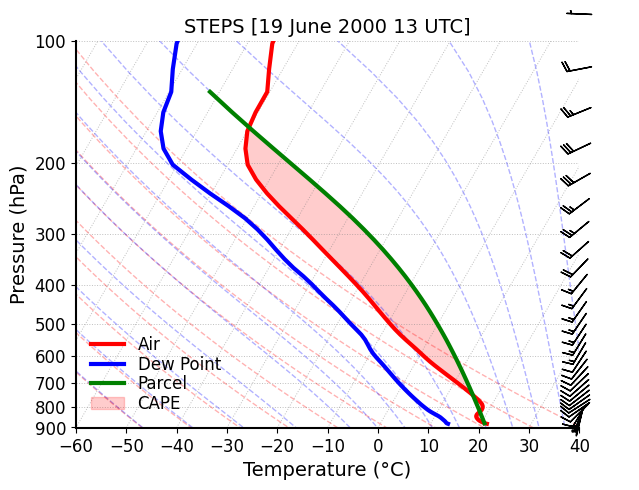

In [99]:
ds_skewt = ds_4sip.sel(time=ds_4sip.time[6])

tempc = ds_skewt.temp-273.15 #.values
pres_pa = ds_skewt.pres #.values
ht_m = ds_skewt.z_mc
rel_hum = ds_skewt.rh #.values
u_wind = ds_skewt.u
v_wind = ds_skewt.v
q_vap = ds_skewt.qv

   
temp_dew = calc_dewpoint(tempc, rel_hum)
#temp_dew = calc_tdew(tempc, rel_hum)

avg_tempc = tempc.mean(dim=('ncells')).values
avg_dewtempc = temp_dew.mean(dim=('ncells')).values
avg_pres = 0.01*pres_pa.mean(dim=('ncells')).values
avg_ht = ht_m.mean(dim=('ncells')).values
avg_rh = rel_hum.mean(dim=('ncells')).values
avg_qv = q_vap.mean(dim=('ncells')).values

avg_u = u_wind.mean(dim=('ncells')).values
avg_v = v_wind.mean(dim=('ncells')).values

avg_tempc = avg_tempc[::-1]
avg_dewtempc = avg_dewtempc[::-1]
avg_pres = avg_pres[::-1]
avg_ht = avg_ht[::-1]
avg_rh = avg_rh[::-1]
avg_u = avg_u[::-1]
avg_v = avg_v[::-1]
avg_qv = avg_qv[::-1]

# Create the Skew-T plot
fontsize=14;
lnwdth=3;
alpha=0.3;

fig = plt.figure(figsize=(8, 5))
skew = SkewT(fig)

skew.plot(avg_pres, avg_tempc, 'r-', label='Air', linewidth=lnwdth)
skew.plot(avg_pres, avg_dewtempc, 'b-', label='Dew Point', linewidth=lnwdth)

skew.plot_dry_adiabats(linewidth=1, alpha=alpha, linestyle='--')
skew.plot_moist_adiabats(linewidth=1, alpha=alpha, linestyle='--')

moist_adiabats = skew.moist_adiabats

# Now, we'll plot parcel path (that follows moist adiabatic line between LFC and LNB)
# We basically skip calculation of parcel temperature and CAPE and make use of the SKEWT plot itself

adiabat_profiles = []
for path in moist_adiabats.get_paths():
    temp_pres = path.vertices
    # We now interpolate temp_pres on available pressure levels
    adiabat_temp = np.interp(avg_pres, 
                           temp_pres[:,1][::-1],  # Pressure values
                           temp_pres[:,0][::-1])  # Temperature values
    adiabat_profiles.append(adiabat_temp)

# Find intersections between environmental temp and moist adiabats (these intersection points are LFC and LNB)
crossing_points = []
for i in range(len(avg_pres)-1):
    for j, adiabat in enumerate(adiabat_profiles):
        if ((avg_tempc[i] > adiabat[i] and avg_tempc[i+1] <= adiabat[i+1]) or 
            (avg_tempc[i] < adiabat[i] and avg_tempc[i+1] >= adiabat[i+1])):
            crossing_points.append((i, j))

# Process crossing points to find LFC and LNB
if len(crossing_points) >= 2:
    # Sort by pressure (descending)
    crossing_points.sort(key=lambda x: avg_pres[x[0]], reverse=True)
    
    lfc_idx, lfc_adiabat_idx = crossing_points[0]
    lnb_idx, lnb_adiabat_idx = crossing_points[-1]
    
    # Create parcel temperature line
    parcel_temp = np.full_like(avg_tempc, np.nan)
    parcel_temp[lfc_idx:lnb_idx+1] = adiabat_profiles[lfc_adiabat_idx][lfc_idx:lnb_idx+1]
    
    # Plot parcel path
    skew.plot(avg_pres, parcel_temp, 'g-', linewidth=lnwdth, label='Parcel')
    
    # Shade CAPE area
    skew.ax.fill_betweenx(avg_pres[lfc_idx:lnb_idx+1],
                        avg_tempc[lfc_idx:lnb_idx+1],
                        parcel_temp[lfc_idx:lnb_idx+1],
                        where=parcel_temp[lfc_idx:lnb_idx+1] > avg_tempc[lfc_idx:lnb_idx+1],
                        color='red', alpha=0.2, label='CAPE')

    # Mark LFC and LNB
    skew.plot(avg_pres[lfc_idx], avg_tempc[lfc_idx], 'k', markersize=10, markeredgewidth=2)#, label='LFC')
    skew.plot(avg_pres[lnb_idx], avg_tempc[lnb_idx], 'k', markersize=10, markeredgewidth=2)#, label='LNB')
    
    # Add text labels
    #plt.text(avg_tempc[lfc_idx]-2, avg_pres[lfc_idx]-10, 'LFC', 
    #        fontsize=fontsize-2, ha='right', va='top')
    #plt.text(avg_tempc[lnb_idx]+2, avg_pres[lnb_idx]+10, 'LNB', 
    #        fontsize=fontsize-2, ha='left', va='bottom')

# Add wind barbs if available
if 'u' in ds_skewt and 'v' in ds_skewt:
    u_wind = avg_u  # Zonal wind component
    v_wind = avg_v  # Meridional wind component
    skew.plot_barbs(avg_pres[::2], u_wind[::2], v_wind[::2], length=6, color='black', pivot='middle')

# Configure plot appearance
ax = skew.ax
ax.set_xlabel('Temperature (°C)', fontsize=fontsize)
ax.set_ylabel('Pressure (hPa)', fontsize=fontsize)
ax.set_xlim(-60, 40)
ax.set_ylim(avg_pres[0]+20, 100)
ax.tick_params(axis='both', labelsize=fontsize-2)

plt.title('STEPS [19 June 2000 13 UTC]', fontsize=fontsize)#, pad=20)

plt.legend(frameon=False, handlelength=2, labelspacing=0.1, fontsize=fontsize-2, loc='lower left')#, bbox_to_anchor=(0.7, 0.95))

plt.grid(True, linestyle=':', linewidth=0.7, color='grey', alpha=0.5)

# Clean up borders
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


In [111]:
print(pres_sonde)
print(e_vap)
print(qv_sonde)

[855.9 848.2 847.8 ...  98.5  98.4  98.3]
[8.32132787e+02 7.81445634e+02 7.72944876e+02 ... 1.90995475e-03
 1.88426486e-03 1.85889224e-03]
[2.17773362e+01 7.28130932e+00 6.42269613e+00 ... 1.20610649e-05
 1.19109267e-05 1.17624907e-05]


CAPE ::  1134.2228793854447
LCL ::  19.015461


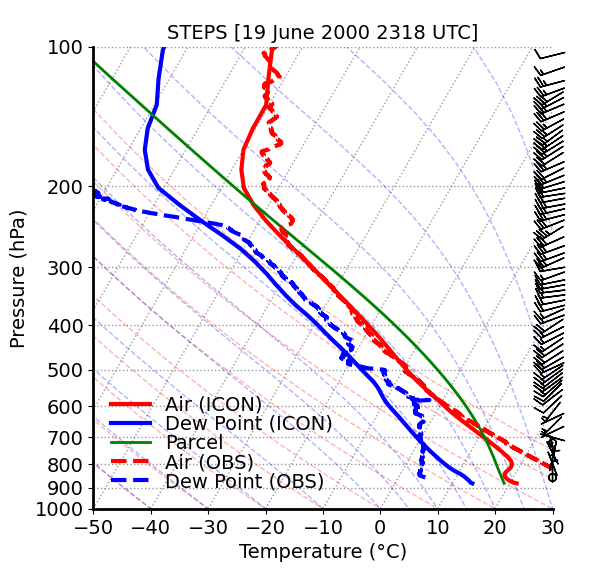

In [110]:

file_path = '/work/bk1415/b382718/output/steps/observations/sounding_data/D200006192318.st1QC.cls'
column_names = ['Time', 'pres', 'temp', 'Tdew', 'relhum', 'u_wind', 'v_wind', 'w_wind', 'w_dir', 'dZ', 'Lon', 'Lat', 'range', 'Az', 'altitude', 'Qp', 'Qt', 'Qh', 'Qu', 'Qv', 'Quv']

# Read the data with column names
ds_sonde = pd.read_csv(file_path, sep='\s+', skiprows=15, names=column_names)

ds_sonde = ds_sonde[(ds_sonde['temp'] != 999.0) & (ds_sonde['pres'] != 9999.0) & 
           (ds_sonde['Tdew'] != 999.0) & (ds_sonde['relhum'] != 999.0) & (ds_sonde['u_wind'] != 999.0) &
           (ds_sonde['v_wind'] != 999.0)& (ds_sonde['w_wind'] != 999.0)& (ds_sonde['altitude'] != 99999.0)] 

temp_sonde = ds_sonde.temp.values
pres_sonde = ds_sonde.pres.values
tdew_sonde = ds_sonde.Tdew.values
rh_sonde = ds_sonde.relhum.values
u_sonde = ds_sonde.u_wind.values
v_sonde = ds_sonde.v_wind.values
w_sonde = ds_sonde.w_wind.values
ht_sonde = ds_sonde.altitude.values

#----- Calculate parcel properties
#e_sat = e_sat_hpa(temp_sonde)
#q_sat = 0.622*e_sat/(pres_sonde-e_sat)

#e_vap = e_sat*rh_sonde
#qv_sonde = 0.622*e_vap/(pres_sonde-e_vap)

#lcl_pressure, lcl_temp = calculate_lcl(pres_sonde, temp_sonde, tdew_sonde)
##lcl_temp = calc_lcl(avg_tempc[0], avg_dewtempc)
#parcel_temp = calc_parcel_temp(pres_sonde, ht_sonde, q_sat, lcl_temp)
#Tv_env = calc_vir_temp(temp_sonde, qv_sonde)
#Tv_parcel = calc_vir_temp(parcel_temp, q_sat)
#parcel_cape = calc_cape(pres_sonde, temp_sonde, parcel_temp, Tv_env, Tv_parcel)
print('CAPE :: ',parcel_cape)
print('LCL :: ', lcl_temp)
#------

# Create the Skew-T plot
fontsize=14;
lnwdth=3;
alpha=0.3;

fig = plt.figure(figsize=(8, 6))
skew = SkewT(fig)

# Plot temperature and dew point on the Skew-T

skew.plot(avg_pres, avg_tempc, 'r-', label='Air (ICON)', linewidth=lnwdth)
skew.plot(avg_pres, avg_dewtempc, 'b-', label='Dew Point (ICON)', linewidth=lnwdth)
skew.plot(avg_pres, parcel_temp, 'g-', label='Parcel', linewidth=lnwdth-1)

skew.plot(pres_sonde, temp_sonde, 'r--', label='Air (OBS)', linewidth=lnwdth)
skew.plot(pres_sonde, tdew_sonde, 'b--', label='Dew Point (OBS)', linewidth=lnwdth)
#skew.plot(pres_sonde, parcel_temp, 'g--', label='Parcel', linewidth=lnwdth-1)

# Add wind barbs 
if 'u' in ds_skewt and 'v' in ds_skewt:
    u_wind = u_sonde  # Zonal wind component
    v_wind = v_sonde  # Meridional wind component
    skew.plot_barbs(pres_sonde[::40], u_wind[::40], v_wind[::40], length=6, color='black', pivot='middle')

# Add the dry and moist adiabats to the plot
skew.plot_dry_adiabats(linewidth=1, alpha=alpha)
skew.plot_moist_adiabats(linewidth=1, alpha=alpha)

ax = skew.ax
ax.set_xlabel('Temperature (°C)', fontsize=fontsize)
ax.set_ylabel('Pressure (hPa)', fontsize=fontsize)
ax.set_xlim(-50, 30)
ax.set_ylim(1000., 100)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
plt.title('STEPS [19 June 2000 2318 UTC]', fontsize=fontsize)

plt.legend(frameon=False, handlelength=2, labelspacing=0.01, fontsize=fontsize, loc='lower left')
plt.grid(True, linestyle=':', linewidth=1., color='grey', alpha=0.8)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.show()

<xarray.DataArray 'time' ()>
array('2000-06-19T18:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2000-06-19T18:00:00
Attributes:
    standard_name:  time
    axis:           T
CAPE ::  1026.5964956477408 joule / kilogram
CIN ::  -39.94582057623424 joule / kilogram


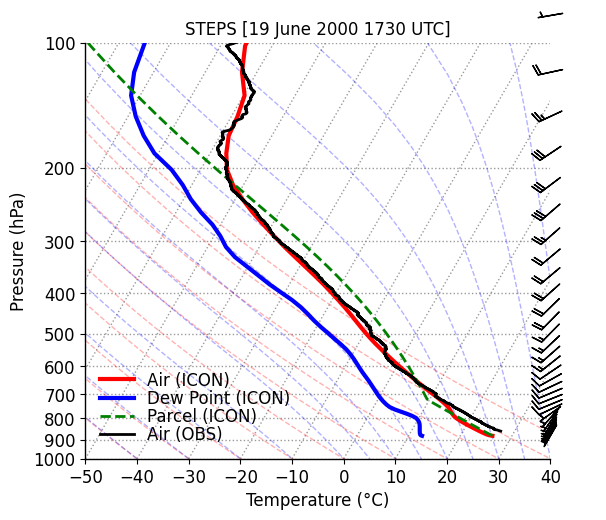

In [32]:

from metpy.calc import dewpoint_from_relative_humidity
from metpy.units import units
from metpy.calc import parcel_profile
from metpy.calc import cape_cin

file_path = '/work/bk1415/b382718/output/steps/observations/sounding_data/D200006191735.st1QC.cls'
column_names = ['Time', 'pres', 'temp', 'Tdew', 'relhum', 'u_wind', 'v_wind', 'w_wind', 'w_dir', 'dZ', 'Lon', 'Lat', 'range', 'Az', 'altitude', 'Qp', 'Qt', 'Qh', 'Qu', 'Qv', 'Quv']

# Read the data with column names
ds_sonde = pd.read_csv(file_path, sep='\s+', skiprows=15, names=column_names)

ds_sonde = ds_sonde[(ds_sonde['temp'] != 999.0) & (ds_sonde['pres'] != 9999.0) & 
           (ds_sonde['Tdew'] != 999.0) & (ds_sonde['relhum'] != 999.0) & (ds_sonde['u_wind'] != 999.0) &
           (ds_sonde['v_wind'] != 999.0)& (ds_sonde['w_wind'] != 999.0)& (ds_sonde['altitude'] != 99999.0)] 

temp_sonde = ds_sonde.temp.values
pres_sonde = ds_sonde.pres.values
tdew_sonde = ds_sonde.Tdew.values
rh_sonde = ds_sonde.relhum.values
u_sonde = ds_sonde.u_wind.values
v_sonde = ds_sonde.v_wind.values
w_sonde = ds_sonde.w_wind.values
ht_sonde = ds_sonde.altitude.values

### ICON
ds_skewt = ds_4sip.sel(time=ds_4sip.time[12])

print(ds_4sip.time[12])

tempc = ds_skewt.temp-273.15 #.values
pres_pa = ds_skewt.pres #.values
ht_m = ds_skewt.z_mc
rel_hum = ds_skewt.rh #.values
u_wind = ds_skewt.u
v_wind = ds_skewt.v
q_vap = ds_skewt.qv

   
temp_dew = calc_dewpoint(tempc, rel_hum)

avg_tempc = tempc.mean(dim=('ncells')).values
avg_dewtempc = temp_dew.mean(dim=('ncells')).values
avg_pres = 0.01*pres_pa.mean(dim=('ncells')).values
avg_ht = ht_m.mean(dim=('ncells')).values
avg_rh = rel_hum.mean(dim=('ncells')).values
avg_qv = q_vap.mean(dim=('ncells')).values

avg_u = u_wind.mean(dim=('ncells')).values
avg_v = v_wind.mean(dim=('ncells')).values

avg_tempc = avg_tempc[::-1]
avg_dewtempc = avg_dewtempc[::-1]
avg_pres = avg_pres[::-1]
avg_ht = avg_ht[::-1]
avg_rh = avg_rh[::-1]
avg_u = avg_u[::-1]
avg_v = avg_v[::-1]
avg_qv = avg_qv[::-1]

### Parcel properties from ICON
temperature_K = (avg_tempc + 273.15) * units.K
relative_humidity = avg_rh / 100.0  # Convert to fraction

dewpoint = dewpoint_from_relative_humidity(temperature_K, relative_humidity)
avg_dewtempc = dewpoint.magnitude #- 273.15

pressure = avg_pres * units.hPa
temperature = avg_tempc * units.degC
dewpoint = avg_dewtempc * units.degC

parcel_tempk = parcel_profile(pressure, temperature[0], dewpoint[0])  # First level
parcel_tempc = parcel_tempk.magnitude-273.15

parcel_tempc = parcel_tempc * units.degC
cape, cin = cape_cin(pressure, temperature, dewpoint, parcel_tempc)

print('CAPE :: ', cape)
print('CIN :: ', cin)
### End parcel properties
### End ICON

# Create the Skew-T plot
fontsize=12;
lnwdth=3;
alpha=0.3;

fig = plt.figure(figsize=(6, 8))
skew = SkewT(fig)

# Plot temperature and dew point on the Skew-T
skew.plot(avg_pres, avg_tempc, 'r-', label='Air (ICON)', linewidth=lnwdth)
skew.plot(avg_pres, avg_dewtempc, 'b-', label='Dew Point (ICON)', linewidth=lnwdth)
skew.plot(avg_pres, parcel_tempc, 'g--', label='Parcel (ICON)', linewidth=lnwdth-1)
skew.plot(pres_sonde* units.hPa, temp_sonde* units.degC, 'k-', label='Air (OBS)', linewidth=lnwdth-1)

# Add wind barbs 
if 'u' in ds_skewt and 'v' in ds_skewt:
    u_wind = avg_u  # Zonal wind component
    v_wind = avg_v  # Meridional wind component
    skew.plot_barbs(avg_pres[::2], u_wind[::2], v_wind[::2], length=6, color='black', pivot='middle')

# Add the dry and moist adiabats to the plot
skew.plot_dry_adiabats(linewidth=1, alpha=alpha)
skew.plot_moist_adiabats(linewidth=1, alpha=alpha)

ax = skew.ax
ax.set_xlabel('Temperature (°C)', fontsize=fontsize)
ax.set_ylabel('Pressure (hPa)', fontsize=fontsize)
ax.set_xlim(-50, 40)
ax.set_ylim(1000., 100)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
plt.title('STEPS [19 June 2000 1730 UTC]', fontsize=fontsize)

plt.legend(frameon=False, handlelength=2, labelspacing=0.01, fontsize=fontsize, loc='lower left')
plt.grid(True, linestyle=':', linewidth=1., color='grey', alpha=0.8)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(1)
plt.gca().spines['bottom'].set_linewidth(1)
plt.show()

In [26]:

thres_w = 2.;
thres_inc = 1.e-4;

filt_inc_nosip = xr.where((ds_nosip.tqi > thres_inc) & (ds_nosip.w_vel > thres_w), ds_nosip.inc_perl, np.nan);
filt_inc_4sip = xr.where((ds_4sip.tqi > thres_inc) & (ds_4sip.w_vel > thres_w), ds_4sip.inc_perl, np.nan);
filt_inc_nohm = xr.where((ds_nohm.tqi > thres_inc) & (ds_nohm.w_vel > thres_w), ds_nohm.inc_perl, np.nan);
filt_inc_norf = xr.where((ds_norf.tqi > thres_inc) & (ds_norf.w_vel > thres_w), ds_norf.inc_perl, np.nan);
filt_inc_nobr = xr.where((ds_nobr.tqi > thres_inc) & (ds_nobr.w_vel > thres_w), ds_nobr.inc_perl, np.nan);
filt_inc_nosb = xr.where((ds_nosb.tqi > thres_inc) & (ds_nosb.w_vel > thres_w), ds_nosb.inc_perl, np.nan);
avg_tempc = ds_4sip.tempc.mean(dim=('time','ncells'))


mean_inc_up_nosip = filt_inc_nosip.mean(dim=('time','ncells'))
mean_inc_up_4sip = filt_inc_4sip.mean(dim=('time','ncells'))
mean_inc_up_nohm = filt_inc_nohm.mean(dim=('time','ncells'))
mean_inc_up_norf = filt_inc_norf.mean(dim=('time','ncells'))
mean_inc_up_nobr = filt_inc_nobr.mean(dim=('time','ncells'))
mean_inc_up_nosb = filt_inc_nosb.mean(dim=('time','ncells'))

filt_inc_nosip = xr.where((ds_nosip.tqi > thres_inc) & (ds_nosip.w_vel < -1.*thres_w), ds_nosip.inc_perl, np.nan);
filt_inc_4sip = xr.where((ds_4sip.tqi > thres_inc) & (ds_4sip.w_vel < -1.*thres_w), ds_4sip.inc_perl, np.nan);
filt_inc_nohm = xr.where((ds_nohm.tqi > thres_inc) & (ds_nohm.w_vel < -1.*thres_w), ds_nohm.inc_perl, np.nan);
filt_inc_norf = xr.where((ds_norf.tqi > thres_inc) & (ds_norf.w_vel < -1.*thres_w), ds_norf.inc_perl, np.nan);
filt_inc_nobr = xr.where((ds_nobr.tqi > thres_inc) & (ds_nobr.w_vel < -1.*thres_w), ds_nobr.inc_perl, np.nan);
filt_inc_nosb = xr.where((ds_nosb.tqi > thres_inc) & (ds_nosb.w_vel < -1.*thres_w), ds_nosb.inc_perl, np.nan);
avg_tempc = ds_4sip.tempc.mean(dim=('time','ncells'))


mean_inc_dn_nosip = filt_inc_nosip.mean(dim=('time','ncells'))
mean_inc_dn_4sip = filt_inc_4sip.mean(dim=('time','ncells'))
mean_inc_dn_nohm = filt_inc_nohm.mean(dim=('time','ncells'))
mean_inc_dn_norf = filt_inc_norf.mean(dim=('time','ncells'))
mean_inc_dn_nobr = filt_inc_nobr.mean(dim=('time','ncells'))
mean_inc_dn_nosb = filt_inc_nosb.mean(dim=('time','ncells'))


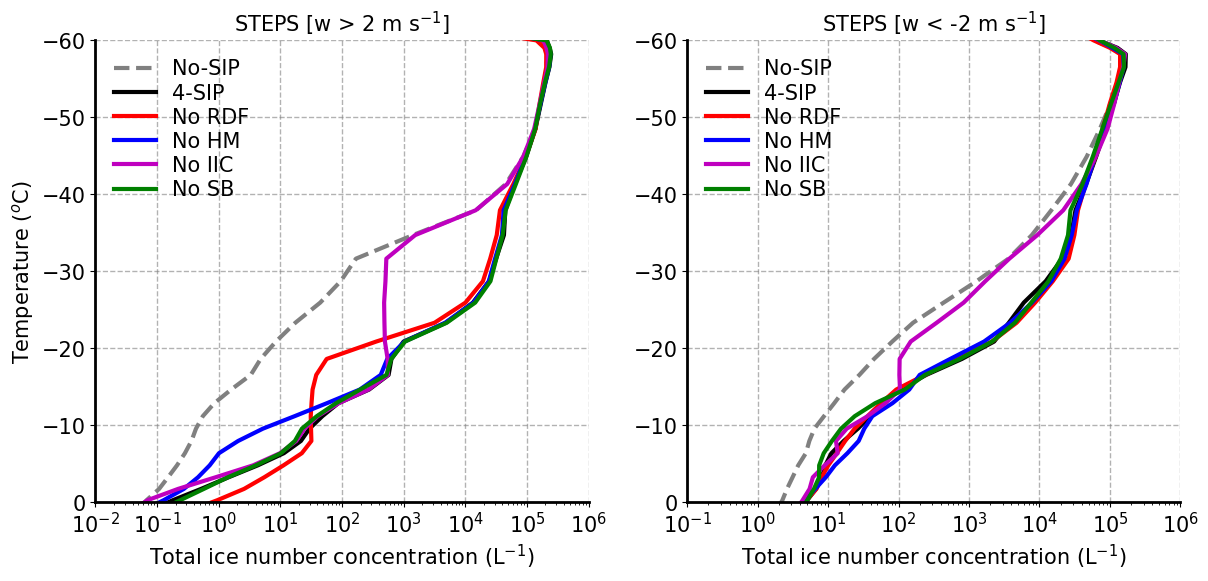

In [29]:

# Plotting
plt.figure(figsize=(14, 6))
deg_faint_errbar = 0.6
lnwdth=3
fontsize=15
plt.subplot(1,2,1)

plt.plot(mean_inc_up_nosip, avg_tempc, '--', color='grey', linewidth=lnwdth, label='No-SIP')
plt.plot(mean_inc_up_4sip, avg_tempc, 'k-', linewidth=lnwdth, label='4-SIP')
plt.plot(mean_inc_up_norf, avg_tempc, 'r-', linewidth=lnwdth, label='No RDF')
plt.plot(mean_inc_up_nohm, avg_tempc, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(mean_inc_up_nobr, avg_tempc, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(mean_inc_up_nosb, avg_tempc, 'g-', linewidth=lnwdth, label='No SB')

plt.grid(True, linestyle='--', color='grey', linewidth=1, alpha=0.6)
plt.xlim(1.e-2, 1.e6)
plt.xticks([1.e-2, 1.e-1, 1.e0, 1.e1, 1.e2, 1.e3, 1.e4, 1.e5, 1.e6], fontsize=fontsize)
plt.ylim(0, -60)
plt.yticks([0, -10, -20, -30, -40, -50, -60], fontsize=fontsize)
plt.xscale('log')
plt.xlabel('Total ice number concentration (L$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('STEPS [w > 2 m s$^{-1}$]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.2, fontsize=fontsize, loc='best')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)

plt.subplot(1,2,2)
plt.plot(mean_inc_dn_nosip, avg_tempc, '--', color='grey', linewidth=lnwdth, label='No-SIP')
plt.plot(mean_inc_dn_4sip, avg_tempc, 'k-', linewidth=lnwdth, label='4-SIP')
plt.plot(mean_inc_dn_norf, avg_tempc, 'r-', linewidth=lnwdth, label='No RDF')
plt.plot(mean_inc_dn_nohm, avg_tempc, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(mean_inc_dn_nobr, avg_tempc, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(mean_inc_dn_nosb, avg_tempc, 'g-', linewidth=lnwdth, label='No SB')

plt.grid(True, linestyle='--', color='grey', linewidth=1, alpha=0.6)
plt.xlim(1.e-1, 1.e6)
plt.xticks([1.e-1, 1.e0, 1.e1, 1.e2, 1.e3, 1.e4, 1.e5, 1.e6], fontsize=fontsize)
plt.ylim(0, -60)
plt.yticks([0, -10, -20, -30, -40, -50, -60], fontsize=fontsize)
plt.xscale('log')
plt.xlabel('Total ice number concentration (L$^{-1}$)', fontsize=fontsize)
#plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('STEPS [w < -2 m s$^{-1}$]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.2, fontsize=fontsize, loc='best')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)

# Show plot
plt.show()


In [40]:

thres_w = 2.;
thres_q = 1.e-9;

filt_nosip = xr.where((ds_nosip.qc > thres_q) & (ds_nosip.w_vel > thres_w), ds_nosip.qc, np.nan);
filt_4sip = xr.where((ds_4sip.qc > thres_q) & (ds_4sip.w_vel > thres_w), ds_4sip.qc, np.nan);
filt_nohm = xr.where((ds_nohm.qc > thres_q) & (ds_nohm.w_vel > thres_w), ds_nohm.qc, np.nan);
filt_norf = xr.where((ds_norf.qc > thres_q) & (ds_norf.w_vel > thres_w), ds_norf.qc, np.nan);
filt_nobr = xr.where((ds_nobr.qc > thres_q) & (ds_nobr.w_vel > thres_w), ds_nobr.qc, np.nan);
filt_nosb = xr.where((ds_nosb.qc > thres_q) & (ds_nosb.w_vel > thres_w), ds_nosb.qc, np.nan);
avg_tempc = ds_4sip.tempc.mean(dim=('time','ncells'))

mean_qc_up_nosip = filt_nosip.mean(dim=('time','ncells'))
mean_qc_up_4sip = filt_4sip.mean(dim=('time','ncells'))
mean_qc_up_nohm = filt_nohm.mean(dim=('time','ncells'))
mean_qc_up_norf = filt_norf.mean(dim=('time','ncells'))
mean_qc_up_nobr = filt_nobr.mean(dim=('time','ncells'))
mean_qc_up_nosb = filt_nosb.mean(dim=('time','ncells'))

filt_nosip = xr.where((ds_nosip.qc > thres_q) & (ds_nosip.w_vel < -1.*thres_w), ds_nosip.qc, np.nan);
filt_4sip = xr.where((ds_4sip.qc > thres_q) & (ds_4sip.w_vel < -1.*thres_w), ds_4sip.qc, np.nan);
filt_nohm = xr.where((ds_nohm.qc > thres_q) & (ds_nohm.w_vel < -1.*thres_w), ds_nohm.qc, np.nan);
filt_norf = xr.where((ds_norf.qc > thres_q) & (ds_norf.w_vel < -1.*thres_w), ds_norf.qc, np.nan);
filt_nobr = xr.where((ds_nobr.qc > thres_q) & (ds_nobr.w_vel < -1.*thres_w), ds_nobr.qc, np.nan);
filt_nosb = xr.where((ds_nosb.qc > thres_q) & (ds_nosb.w_vel < -1.*thres_w), ds_nosb.qc, np.nan);
avg_tempc = ds_4sip.tempc.mean(dim=('time','ncells'))


mean_qc_dn_nosip = filt_nosip.mean(dim=('time','ncells'))
mean_qc_dn_4sip = filt_4sip.mean(dim=('time','ncells'))
mean_qc_dn_nohm = filt_nohm.mean(dim=('time','ncells'))
mean_qc_dn_norf = filt_norf.mean(dim=('time','ncells'))
mean_qc_dn_nobr = filt_nobr.mean(dim=('time','ncells'))
mean_qc_dn_nosb = filt_nosb.mean(dim=('time','ncells'))


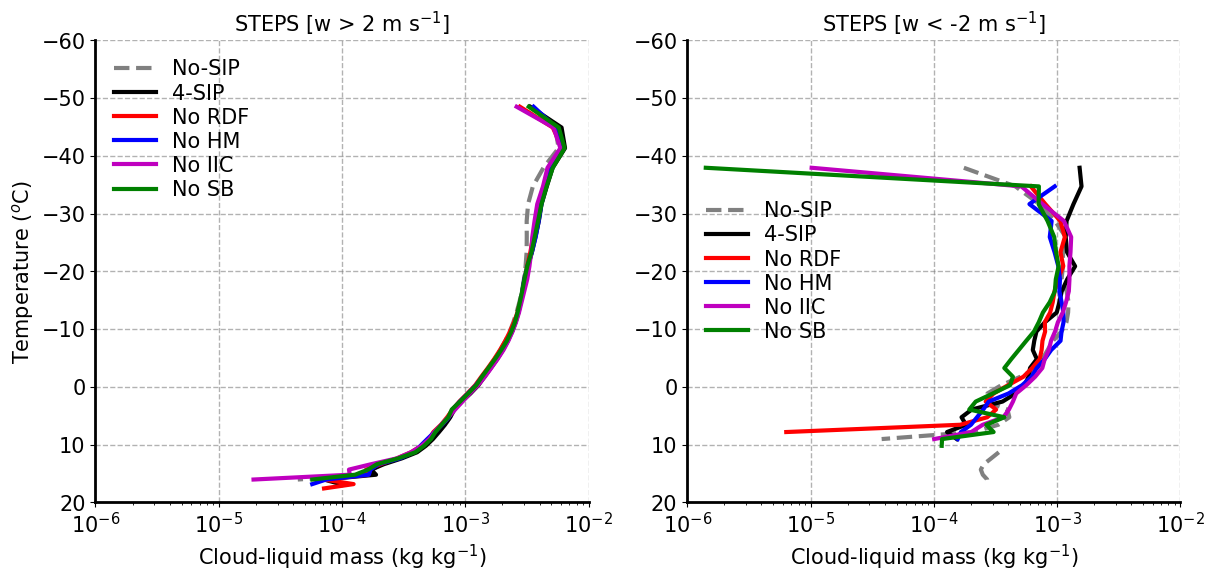

In [41]:

# Plotting
plt.figure(figsize=(14, 6))
deg_faint_errbar = 0.6
lnwdth=3
fontsize=15
plt.subplot(1,2,1)

plt.plot(mean_qc_up_nosip, avg_tempc, '--', color='grey', linewidth=lnwdth, label='No-SIP')
plt.plot(mean_qc_up_4sip, avg_tempc, 'k-', linewidth=lnwdth, label='4-SIP')
plt.plot(mean_qc_up_norf, avg_tempc, 'r-', linewidth=lnwdth, label='No RDF')
plt.plot(mean_qc_up_nohm, avg_tempc, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(mean_qc_up_nobr, avg_tempc, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(mean_qc_up_nosb, avg_tempc, 'g-', linewidth=lnwdth, label='No SB')

plt.grid(True, linestyle='--', color='grey', linewidth=1, alpha=0.6)
plt.xlim(1.e-6, 1.e-2)
plt.xticks([1.e-6, 1.e-5, 1.e-4, 1.e-3, 1.e-2], fontsize=fontsize)
plt.ylim(20, -60)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60], fontsize=fontsize)
plt.xscale('log')
plt.xlabel('Cloud-liquid mass (kg kg$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('STEPS [w > 2 m s$^{-1}$]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.2, fontsize=fontsize, loc='best')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)

plt.subplot(1,2,2)
plt.plot(mean_qc_dn_nosip, avg_tempc, '--', color='grey', linewidth=lnwdth, label='No-SIP')
plt.plot(mean_qc_dn_4sip, avg_tempc, 'k-', linewidth=lnwdth, label='4-SIP')
plt.plot(mean_qc_dn_norf, avg_tempc, 'r-', linewidth=lnwdth, label='No RDF')
plt.plot(mean_qc_dn_nohm, avg_tempc, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(mean_qc_dn_nobr, avg_tempc, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(mean_qc_dn_nosb, avg_tempc, 'g-', linewidth=lnwdth, label='No SB')

plt.grid(True, linestyle='--', color='grey', linewidth=1, alpha=0.6)
plt.xlim(1.e-6, 1.e-2)
plt.xticks([1.e-6, 1.e-5, 1.e-4, 1.e-3, 1.e-2], fontsize=fontsize)
plt.ylim(20, -60)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60], fontsize=fontsize)
plt.xscale('log')
plt.xlabel('Cloud-liquid mass (kg kg$^{-1}$)', fontsize=fontsize)
#plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('STEPS [w < -2 m s$^{-1}$]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.2, fontsize=fontsize, loc='best')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)

# Show plot
plt.show()


In [30]:

thres_w = 2.;
thres_q = 1.e-9;

filt_nosip = xr.where((ds_nosip.qr > thres_q) & (ds_nosip.w_vel > thres_w), ds_nosip.qr, np.nan);
filt_4sip = xr.where((ds_4sip.qr > thres_q) & (ds_4sip.w_vel > thres_w), ds_4sip.qr, np.nan);
filt_nohm = xr.where((ds_nohm.qr > thres_q) & (ds_nohm.w_vel > thres_w), ds_nohm.qr, np.nan);
filt_norf = xr.where((ds_norf.qr > thres_q) & (ds_norf.w_vel > thres_w), ds_norf.qr, np.nan);
filt_nobr = xr.where((ds_nobr.qr > thres_q) & (ds_nobr.w_vel > thres_w), ds_nobr.qr, np.nan);
filt_nosb = xr.where((ds_nosb.qr > thres_q) & (ds_nosb.w_vel > thres_w), ds_nosb.qr, np.nan);
avg_tempc = ds_4sip.tempc.mean(dim=('time','ncells'))

mean_qr_up_nosip = filt_nosip.mean(dim=('time','ncells'))
mean_qr_up_4sip = filt_4sip.mean(dim=('time','ncells'))
mean_qr_up_nohm = filt_nohm.mean(dim=('time','ncells'))
mean_qr_up_norf = filt_norf.mean(dim=('time','ncells'))
mean_qr_up_nobr = filt_nobr.mean(dim=('time','ncells'))
mean_qr_up_nosb = filt_nosb.mean(dim=('time','ncells'))

filt_nosip = xr.where((ds_nosip.qr > thres_q) & (ds_nosip.w_vel < -1.*thres_w), ds_nosip.qr, np.nan);
filt_4sip = xr.where((ds_4sip.qr > thres_q) & (ds_4sip.w_vel < -1.*thres_w), ds_4sip.qr, np.nan);
filt_nohm = xr.where((ds_nohm.qr > thres_q) & (ds_nohm.w_vel < -1.*thres_w), ds_nohm.qr, np.nan);
filt_norf = xr.where((ds_norf.qr > thres_q) & (ds_norf.w_vel < -1.*thres_w), ds_norf.qr, np.nan);
filt_nobr = xr.where((ds_nobr.qr > thres_q) & (ds_nobr.w_vel < -1.*thres_w), ds_nobr.qr, np.nan);
filt_nosb = xr.where((ds_nosb.qr > thres_q) & (ds_nosb.w_vel < -1.*thres_w), ds_nosb.qr, np.nan);
avg_tempc = ds_4sip.tempc.mean(dim=('time','ncells'))


mean_qr_dn_nosip = filt_nosip.mean(dim=('time','ncells'))
mean_qr_dn_4sip = filt_4sip.mean(dim=('time','ncells'))
mean_qr_dn_nohm = filt_nohm.mean(dim=('time','ncells'))
mean_qr_dn_norf = filt_norf.mean(dim=('time','ncells'))
mean_qr_dn_nobr = filt_nobr.mean(dim=('time','ncells'))
mean_qr_dn_nosb = filt_nosb.mean(dim=('time','ncells'))


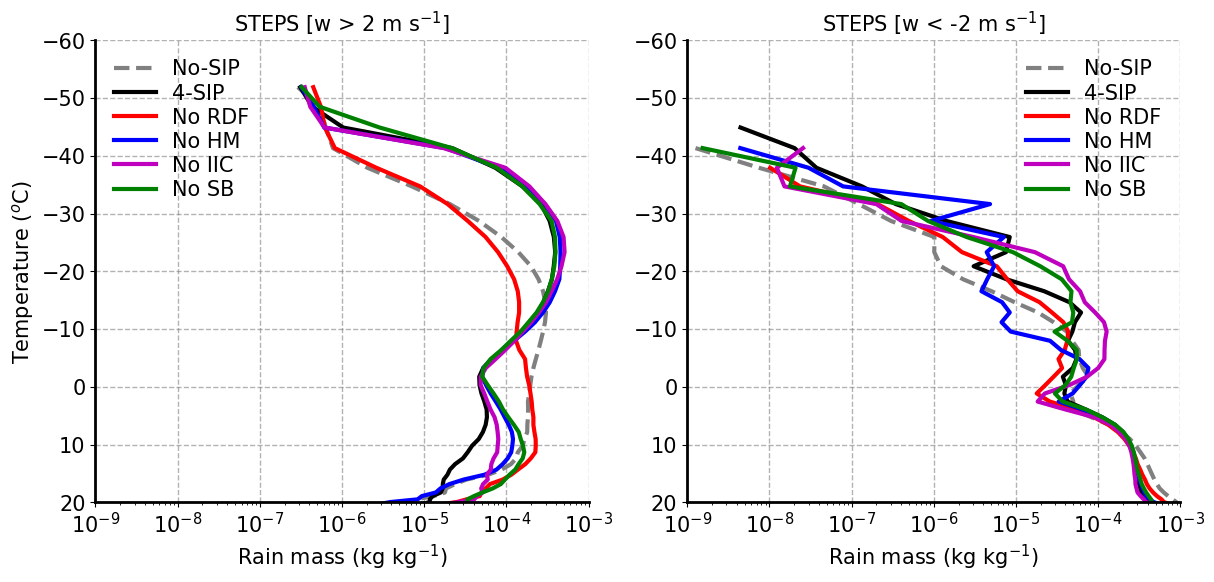

In [33]:

# Plotting
plt.figure(figsize=(14, 6))
deg_faint_errbar = 0.6
lnwdth=3
fontsize=15
plt.subplot(1,2,1)

plt.plot(mean_qr_up_nosip, avg_tempc, '--', color='grey', linewidth=lnwdth, label='No-SIP')
plt.plot(mean_qr_up_4sip, avg_tempc, 'k-', linewidth=lnwdth, label='4-SIP')
plt.plot(mean_qr_up_norf, avg_tempc, 'r-', linewidth=lnwdth, label='No RDF')
plt.plot(mean_qr_up_nohm, avg_tempc, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(mean_qr_up_nobr, avg_tempc, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(mean_qr_up_nosb, avg_tempc, 'g-', linewidth=lnwdth, label='No SB')

plt.grid(True, linestyle='--', color='grey', linewidth=1, alpha=0.6)
plt.xlim(1.e-9, 1.e-3)
plt.xticks([1.e-9, 1.e-8, 1.e-7, 1.e-6, 1.e-5, 1.e-4, 1.e-3], fontsize=fontsize)
plt.ylim(20, -60)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60], fontsize=fontsize)
plt.xscale('log')
plt.xlabel('Rain mass (kg kg$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('STEPS [w > 2 m s$^{-1}$]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.2, fontsize=fontsize, loc='best')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)

plt.subplot(1,2,2)
plt.plot(mean_qr_dn_nosip, avg_tempc, '--', color='grey', linewidth=lnwdth, label='No-SIP')
plt.plot(mean_qr_dn_4sip, avg_tempc, 'k-', linewidth=lnwdth, label='4-SIP')
plt.plot(mean_qr_dn_norf, avg_tempc, 'r-', linewidth=lnwdth, label='No RDF')
plt.plot(mean_qr_dn_nohm, avg_tempc, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(mean_qr_dn_nobr, avg_tempc, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(mean_qr_dn_nosb, avg_tempc, 'g-', linewidth=lnwdth, label='No SB')

plt.grid(True, linestyle='--', color='grey', linewidth=1, alpha=0.6)
plt.xlim(1.e-9, 1.e-3)
plt.xticks([1.e-9, 1.e-8, 1.e-7, 1.e-6, 1.e-5, 1.e-4, 1.e-3], fontsize=fontsize)
plt.ylim(20, -60)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60], fontsize=fontsize)
plt.xscale('log')
plt.xlabel('Rain mass (kg kg$^{-1}$)', fontsize=fontsize)
#plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('STEPS [w < -2 m s$^{-1}$]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.2, fontsize=fontsize, loc='best')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)

# Show plot
plt.show()


In [34]:

thres_w = 2.;
thres_q = 1.e-9;

filt_nosip = xr.where((ds_nosip.qi > thres_q) & (ds_nosip.w_vel > thres_w), ds_nosip.qi, np.nan);
filt_4sip = xr.where((ds_4sip.qi > thres_q) & (ds_4sip.w_vel > thres_w), ds_4sip.qi, np.nan);
filt_nohm = xr.where((ds_nohm.qi > thres_q) & (ds_nohm.w_vel > thres_w), ds_nohm.qi, np.nan);
filt_norf = xr.where((ds_norf.qi > thres_q) & (ds_norf.w_vel > thres_w), ds_norf.qi, np.nan);
filt_nobr = xr.where((ds_nobr.qi > thres_q) & (ds_nobr.w_vel > thres_w), ds_nobr.qi, np.nan);
filt_nosb = xr.where((ds_nosb.qi > thres_q) & (ds_nosb.w_vel > thres_w), ds_nosb.qi, np.nan);
avg_tempc = ds_4sip.tempc.mean(dim=('time','ncells'))

mean_qi_up_nosip = filt_nosip.mean(dim=('time','ncells'))
mean_qi_up_4sip = filt_4sip.mean(dim=('time','ncells'))
mean_qi_up_nohm = filt_nohm.mean(dim=('time','ncells'))
mean_qi_up_norf = filt_norf.mean(dim=('time','ncells'))
mean_qi_up_nobr = filt_nobr.mean(dim=('time','ncells'))
mean_qi_up_nosb = filt_nosb.mean(dim=('time','ncells'))

filt_nosip = xr.where((ds_nosip.qi > thres_q) & (ds_nosip.w_vel < -1.*thres_w), ds_nosip.qi, np.nan);
filt_4sip = xr.where((ds_4sip.qi > thres_q) & (ds_4sip.w_vel < -1.*thres_w), ds_4sip.qi, np.nan);
filt_nohm = xr.where((ds_nohm.qi > thres_q) & (ds_nohm.w_vel < -1.*thres_w), ds_nohm.qi, np.nan);
filt_norf = xr.where((ds_norf.qi > thres_q) & (ds_norf.w_vel < -1.*thres_w), ds_norf.qi, np.nan);
filt_nobr = xr.where((ds_nobr.qi > thres_q) & (ds_nobr.w_vel < -1.*thres_w), ds_nobr.qi, np.nan);
filt_nosb = xr.where((ds_nosb.qi > thres_q) & (ds_nosb.w_vel < -1.*thres_w), ds_nosb.qi, np.nan);
avg_tempc = ds_4sip.tempc.mean(dim=('time','ncells'))

mean_qi_dn_nosip = filt_nosip.mean(dim=('time','ncells'))
mean_qi_dn_4sip = filt_4sip.mean(dim=('time','ncells'))
mean_qi_dn_nohm = filt_nohm.mean(dim=('time','ncells'))
mean_qi_dn_norf = filt_norf.mean(dim=('time','ncells'))
mean_qi_dn_nobr = filt_nobr.mean(dim=('time','ncells'))
mean_qi_dn_nosb = filt_nosb.mean(dim=('time','ncells'))


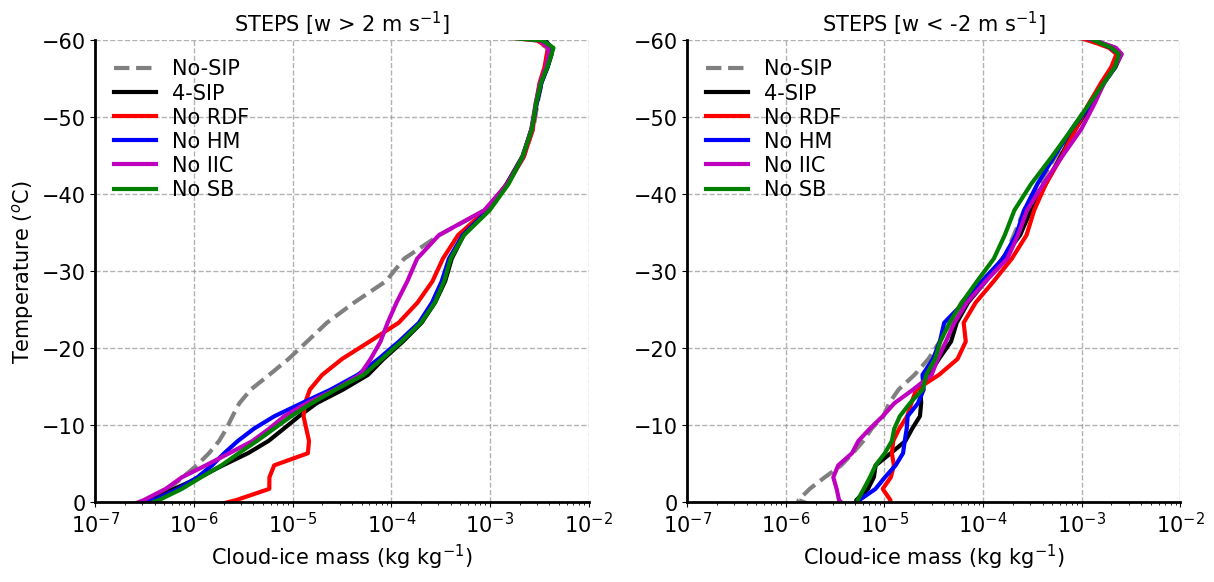

In [42]:

# Plotting
plt.figure(figsize=(14, 6))
deg_faint_errbar = 0.6
lnwdth=3
fontsize=15
plt.subplot(1,2,1)

plt.plot(mean_qi_up_nosip, avg_tempc, '--', color='grey', linewidth=lnwdth, label='No-SIP')
plt.plot(mean_qi_up_4sip, avg_tempc, 'k-', linewidth=lnwdth, label='4-SIP')
plt.plot(mean_qi_up_norf, avg_tempc, 'r-', linewidth=lnwdth, label='No RDF')
plt.plot(mean_qi_up_nohm, avg_tempc, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(mean_qi_up_nobr, avg_tempc, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(mean_qi_up_nosb, avg_tempc, 'g-', linewidth=lnwdth, label='No SB')

plt.grid(True, linestyle='--', color='grey', linewidth=1, alpha=0.6)
plt.xlim(1.e-7, 1.e-2)
plt.xticks([1.e-7, 1.e-6, 1.e-5, 1.e-4, 1.e-3, 1.e-2], fontsize=fontsize)
plt.ylim(0, -60)
plt.yticks([0, -10, -20, -30, -40, -50, -60], fontsize=fontsize)
plt.xscale('log')
plt.xlabel('Cloud-ice mass (kg kg$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('STEPS [w > 2 m s$^{-1}$]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.2, fontsize=fontsize, loc='upper left')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)

plt.subplot(1,2,2)
plt.plot(mean_qi_dn_nosip, avg_tempc, '--', color='grey', linewidth=lnwdth, label='No-SIP')
plt.plot(mean_qi_dn_4sip, avg_tempc, 'k-', linewidth=lnwdth, label='4-SIP')
plt.plot(mean_qi_dn_norf, avg_tempc, 'r-', linewidth=lnwdth, label='No RDF')
plt.plot(mean_qi_dn_nohm, avg_tempc, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(mean_qi_dn_nobr, avg_tempc, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(mean_qi_dn_nosb, avg_tempc, 'g-', linewidth=lnwdth, label='No SB')

plt.grid(True, linestyle='--', color='grey', linewidth=1, alpha=0.6)
plt.xlim(1.e-7, 1.e-2)
plt.xticks([1.e-7, 1.e-6, 1.e-5, 1.e-4, 1.e-3, 1.e-2], fontsize=fontsize)
plt.ylim(0, -60)
plt.yticks([0, -10, -20, -30, -40, -50, -60], fontsize=fontsize)
plt.xscale('log')
plt.xlabel('Cloud-ice mass (kg kg$^{-1}$)', fontsize=fontsize)
#plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('STEPS [w < -2 m s$^{-1}$]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.2, fontsize=fontsize, loc='upper left')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)

# Show plot
plt.show()


In [43]:

thres_w = 2.;
thres_q = 1.e-9;

filt_nosip = xr.where((ds_nosip.qs > thres_q) & (ds_nosip.w_vel > thres_w), ds_nosip.qs, np.nan);
filt_4sip = xr.where((ds_4sip.qs > thres_q) & (ds_4sip.w_vel > thres_w), ds_4sip.qs, np.nan);
filt_nohm = xr.where((ds_nohm.qs > thres_q) & (ds_nohm.w_vel > thres_w), ds_nohm.qs, np.nan);
filt_norf = xr.where((ds_norf.qs > thres_q) & (ds_norf.w_vel > thres_w), ds_norf.qs, np.nan);
filt_nobr = xr.where((ds_nobr.qs > thres_q) & (ds_nobr.w_vel > thres_w), ds_nobr.qs, np.nan);
filt_nosb = xr.where((ds_nosb.qs > thres_q) & (ds_nosb.w_vel > thres_w), ds_nosb.qs, np.nan);
avg_tempc = ds_4sip.tempc.mean(dim=('time','ncells'))

mean_qs_up_nosip = filt_nosip.mean(dim=('time','ncells'))
mean_qs_up_4sip = filt_4sip.mean(dim=('time','ncells'))
mean_qs_up_nohm = filt_nohm.mean(dim=('time','ncells'))
mean_qs_up_norf = filt_norf.mean(dim=('time','ncells'))
mean_qs_up_nobr = filt_nobr.mean(dim=('time','ncells'))
mean_qs_up_nosb = filt_nosb.mean(dim=('time','ncells'))

filt_nosip = xr.where((ds_nosip.qs > thres_q) & (ds_nosip.w_vel < -1.*thres_w), ds_nosip.qs, np.nan);
filt_4sip = xr.where((ds_4sip.qs > thres_q) & (ds_4sip.w_vel < -1.*thres_w), ds_4sip.qs, np.nan);
filt_nohm = xr.where((ds_nohm.qs > thres_q) & (ds_nohm.w_vel < -1.*thres_w), ds_nohm.qs, np.nan);
filt_norf = xr.where((ds_norf.qs > thres_q) & (ds_norf.w_vel < -1.*thres_w), ds_norf.qs, np.nan);
filt_nobr = xr.where((ds_nobr.qs > thres_q) & (ds_nobr.w_vel < -1.*thres_w), ds_nobr.qs, np.nan);
filt_nosb = xr.where((ds_nosb.qs > thres_q) & (ds_nosb.w_vel < -1.*thres_w), ds_nosb.qs, np.nan);
avg_tempc = ds_4sip.tempc.mean(dim=('time','ncells'))

mean_qs_dn_nosip = filt_nosip.mean(dim=('time','ncells'))
mean_qs_dn_4sip = filt_4sip.mean(dim=('time','ncells'))
mean_qs_dn_nohm = filt_nohm.mean(dim=('time','ncells'))
mean_qs_dn_norf = filt_norf.mean(dim=('time','ncells'))
mean_qs_dn_nobr = filt_nobr.mean(dim=('time','ncells'))
mean_qs_dn_nosb = filt_nosb.mean(dim=('time','ncells'))


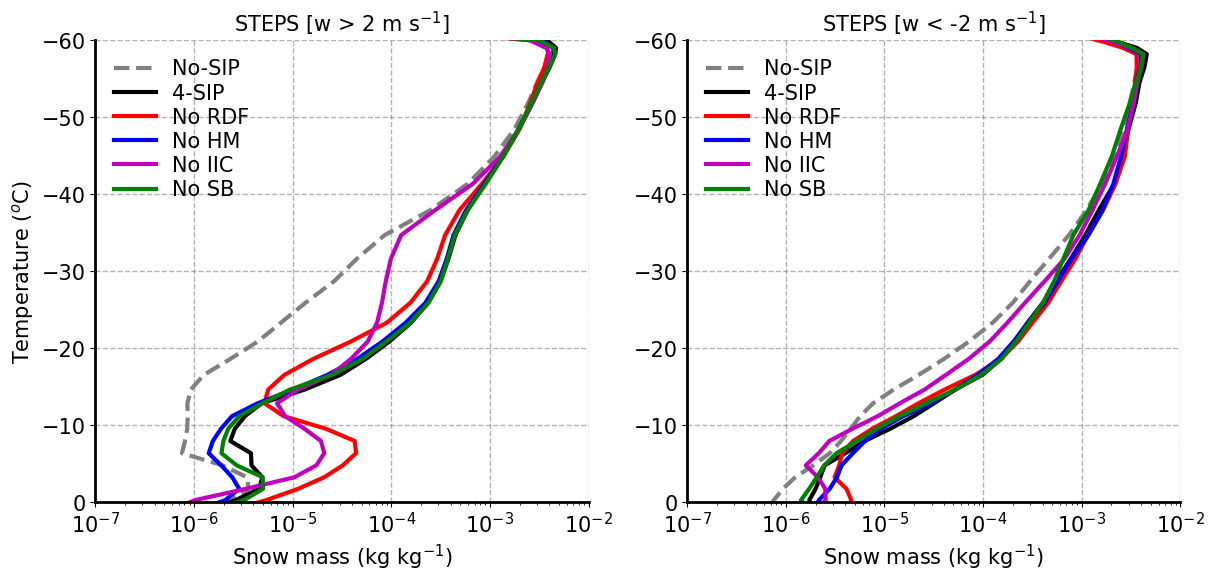

In [46]:

# Plotting
plt.figure(figsize=(14, 6))
deg_faint_errbar = 0.6
lnwdth=3
fontsize=15
plt.subplot(1,2,1)

plt.plot(mean_qs_up_nosip, avg_tempc, '--', color='grey', linewidth=lnwdth, label='No-SIP')
plt.plot(mean_qs_up_4sip, avg_tempc, 'k-', linewidth=lnwdth, label='4-SIP')
plt.plot(mean_qs_up_norf, avg_tempc, 'r-', linewidth=lnwdth, label='No RDF')
plt.plot(mean_qs_up_nohm, avg_tempc, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(mean_qs_up_nobr, avg_tempc, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(mean_qs_up_nosb, avg_tempc, 'g-', linewidth=lnwdth, label='No SB')

plt.grid(True, linestyle='--', color='grey', linewidth=1, alpha=0.6)
plt.xlim(1.e-7, 1.e-2)
plt.xticks([1.e-7, 1.e-6, 1.e-5, 1.e-4, 1.e-3, 1.e-2], fontsize=fontsize)
plt.ylim(0, -60)
plt.yticks([0, -10, -20, -30, -40, -50, -60], fontsize=fontsize)
plt.xscale('log')
plt.xlabel('Snow mass (kg kg$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('STEPS [w > 2 m s$^{-1}$]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.2, fontsize=fontsize, loc='upper left')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)

plt.subplot(1,2,2)
plt.plot(mean_qs_dn_nosip, avg_tempc, '--', color='grey', linewidth=lnwdth, label='No-SIP')
plt.plot(mean_qs_dn_4sip, avg_tempc, 'k-', linewidth=lnwdth, label='4-SIP')
plt.plot(mean_qs_dn_norf, avg_tempc, 'r-', linewidth=lnwdth, label='No RDF')
plt.plot(mean_qs_dn_nohm, avg_tempc, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(mean_qs_dn_nobr, avg_tempc, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(mean_qs_dn_nosb, avg_tempc, 'g-', linewidth=lnwdth, label='No SB')

plt.grid(True, linestyle='--', color='grey', linewidth=1, alpha=0.6)
plt.xlim(1.e-7, 1.e-2)
plt.xticks([1.e-7, 1.e-6, 1.e-5, 1.e-4, 1.e-3, 1.e-2], fontsize=fontsize)
plt.ylim(0, -60)
plt.yticks([0, -10, -20, -30, -40, -50, -60], fontsize=fontsize)
plt.xscale('log')
plt.xlabel('Snow mass (kg kg$^{-1}$)', fontsize=fontsize)
#plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('STEPS [w < -2 m s$^{-1}$]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.2, fontsize=fontsize, loc='upper left')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)

# Show plot
plt.show()


In [47]:

thres_w = 2.;
thres_q = 1.e-9;

filt_nosip = xr.where((ds_nosip.qg > thres_q) & (ds_nosip.w_vel > thres_w), ds_nosip.qg, np.nan);
filt_4sip = xr.where((ds_4sip.qg > thres_q) & (ds_4sip.w_vel > thres_w), ds_4sip.qg, np.nan);
filt_nohm = xr.where((ds_nohm.qg > thres_q) & (ds_nohm.w_vel > thres_w), ds_nohm.qg, np.nan);
filt_norf = xr.where((ds_norf.qg > thres_q) & (ds_norf.w_vel > thres_w), ds_norf.qg, np.nan);
filt_nobr = xr.where((ds_nobr.qg > thres_q) & (ds_nobr.w_vel > thres_w), ds_nobr.qg, np.nan);
filt_nosb = xr.where((ds_nosb.qg > thres_q) & (ds_nosb.w_vel > thres_w), ds_nosb.qg, np.nan);
avg_tempc = ds_4sip.tempc.mean(dim=('time','ncells'))

mean_qg_up_nosip = filt_nosip.mean(dim=('time','ncells'))
mean_qg_up_4sip = filt_4sip.mean(dim=('time','ncells'))
mean_qg_up_nohm = filt_nohm.mean(dim=('time','ncells'))
mean_qg_up_norf = filt_norf.mean(dim=('time','ncells'))
mean_qg_up_nobr = filt_nobr.mean(dim=('time','ncells'))
mean_qg_up_nosb = filt_nosb.mean(dim=('time','ncells'))

filt_nosip = xr.where((ds_nosip.qg > thres_q) & (ds_nosip.w_vel < -1.*thres_w), ds_nosip.qg, np.nan);
filt_4sip = xr.where((ds_4sip.qg > thres_q) & (ds_4sip.w_vel < -1.*thres_w), ds_4sip.qg, np.nan);
filt_nohm = xr.where((ds_nohm.qg > thres_q) & (ds_nohm.w_vel < -1.*thres_w), ds_nohm.qg, np.nan);
filt_norf = xr.where((ds_norf.qg > thres_q) & (ds_norf.w_vel < -1.*thres_w), ds_norf.qg, np.nan);
filt_nobr = xr.where((ds_nobr.qg > thres_q) & (ds_nobr.w_vel < -1.*thres_w), ds_nobr.qg, np.nan);
filt_nosb = xr.where((ds_nosb.qg > thres_q) & (ds_nosb.w_vel < -1.*thres_w), ds_nosb.qg, np.nan);
avg_tempc = ds_4sip.tempc.mean(dim=('time','ncells'))

mean_qg_dn_nosip = filt_nosip.mean(dim=('time','ncells'))
mean_qg_dn_4sip = filt_4sip.mean(dim=('time','ncells'))
mean_qg_dn_nohm = filt_nohm.mean(dim=('time','ncells'))
mean_qg_dn_norf = filt_norf.mean(dim=('time','ncells'))
mean_qg_dn_nobr = filt_nobr.mean(dim=('time','ncells'))
mean_qg_dn_nosb = filt_nosb.mean(dim=('time','ncells'))


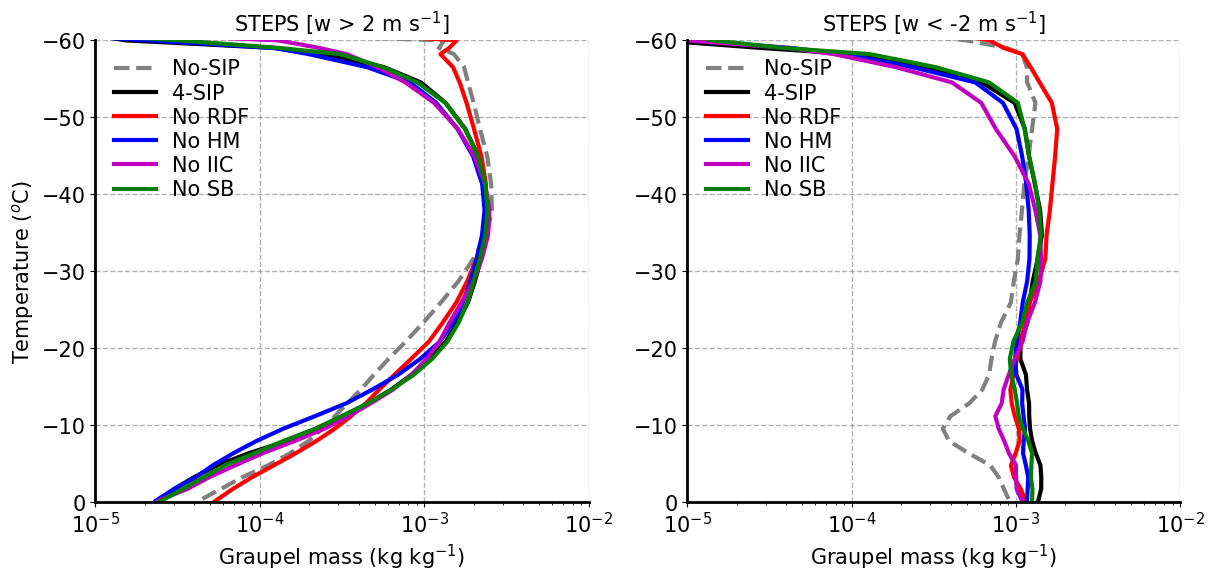

In [49]:

# Plotting
plt.figure(figsize=(14, 6))
deg_faint_errbar = 0.6
lnwdth=3
fontsize=15
plt.subplot(1,2,1)

plt.plot(mean_qg_up_nosip, avg_tempc, '--', color='grey', linewidth=lnwdth, label='No-SIP')
plt.plot(mean_qg_up_4sip, avg_tempc, 'k-', linewidth=lnwdth, label='4-SIP')
plt.plot(mean_qg_up_norf, avg_tempc, 'r-', linewidth=lnwdth, label='No RDF')
plt.plot(mean_qg_up_nohm, avg_tempc, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(mean_qg_up_nobr, avg_tempc, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(mean_qg_up_nosb, avg_tempc, 'g-', linewidth=lnwdth, label='No SB')

plt.grid(True, linestyle='--', color='grey', linewidth=1, alpha=0.6)
plt.xlim(1.e-5, 1.e-2)
plt.xticks([1.e-5, 1.e-4, 1.e-3, 1.e-2], fontsize=fontsize)
plt.ylim(0, -60)
plt.yticks([0, -10, -20, -30, -40, -50, -60], fontsize=fontsize)
plt.xscale('log')
plt.xlabel('Graupel mass (kg kg$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('STEPS [w > 2 m s$^{-1}$]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.2, fontsize=fontsize, loc='upper left')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)

plt.subplot(1,2,2)
plt.plot(mean_qg_dn_nosip, avg_tempc, '--', color='grey', linewidth=lnwdth, label='No-SIP')
plt.plot(mean_qg_dn_4sip, avg_tempc, 'k-', linewidth=lnwdth, label='4-SIP')
plt.plot(mean_qg_dn_norf, avg_tempc, 'r-', linewidth=lnwdth, label='No RDF')
plt.plot(mean_qg_dn_nohm, avg_tempc, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(mean_qg_dn_nobr, avg_tempc, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(mean_qg_dn_nosb, avg_tempc, 'g-', linewidth=lnwdth, label='No SB')

plt.grid(True, linestyle='--', color='grey', linewidth=1, alpha=0.6)
plt.xlim(1.e-5, 1.e-2)
plt.xticks([1.e-5, 1.e-4, 1.e-3, 1.e-2], fontsize=fontsize)
plt.ylim(0, -60)
plt.yticks([0, -10, -20, -30, -40, -50, -60], fontsize=fontsize)
plt.xscale('log')
plt.xlabel('Graupel mass (kg kg$^{-1}$)', fontsize=fontsize)
#plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('STEPS [w < -2 m s$^{-1}$]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.2, fontsize=fontsize, loc='upper left')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)

# Show plot
plt.show()


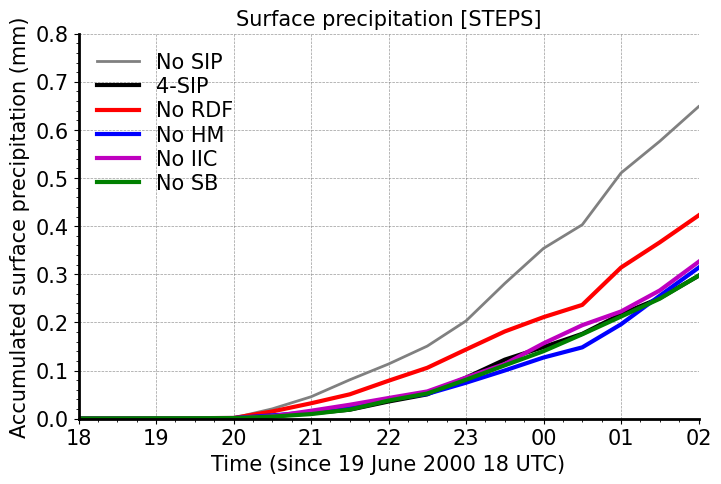

In [59]:

acc_precip_nosip = ds_nosip.tot_prec.mean('ncells')
acc_precip_4sip = ds_4sip.tot_prec.mean('ncells')
acc_precip_nohm = ds_nohm.tot_prec.mean('ncells')
acc_precip_nobr = ds_nobr.tot_prec.mean('ncells')
acc_precip_norf = ds_norf.tot_prec.mean('ncells')
acc_precip_nosb = ds_nosb.tot_prec.mean('ncells')

fontsize=15
linwdth = 3.
plt.figure(figsize=(8, 5))
plt.plot(ds_nosip.time, acc_precip_nosip, "-", color='grey', label="No SIP", linewidth = 2)
plt.plot(ds_4sip.time, acc_precip_4sip, "k-", label="4-SIP", linewidth = linwdth)
plt.plot(ds_norf.time, acc_precip_norf, "r-", label="No RDF", linewidth = linwdth)
plt.plot(ds_nohm.time, acc_precip_nohm, "b-", label="No HM", linewidth = linwdth)
plt.plot(ds_nobr.time, acc_precip_nobr, "m-", label="No IIC", linewidth = linwdth)
plt.plot(ds_nosb.time, acc_precip_nosb, "g-", label="No SB", linewidth = linwdth)

plt.grid(True, linestyle='--', color='grey', linewidth=0.5, alpha=0.8)
plt.minorticks_on()
plt.ylim(0, 0.8)
plt.xlabel('Time (since 19 June 2000 18 UTC)', fontsize=fontsize)
plt.ylabel('Accumulated surface precipitation (mm)', fontsize=fontsize)
start_date = datetime(2000, 6, 19, 18, 0)  # Start at 00 UTC on 10 May 2011
end_date = datetime(2000, 6, 20, 2, 0)
plt.xlim(start_date, end_date)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title('Surface precipitation [STEPS]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.2, fontsize=fontsize, loc='upper left')#, ncol = 1, fontsize='16', bbox_to_anchor=(1.02, 1.02))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.show()


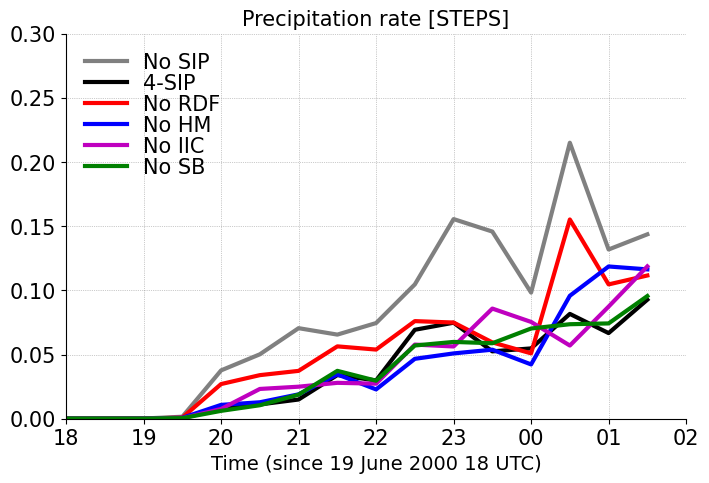

In [61]:

ds_nosb.tot_prec

del_prec_nosip = ds_nosip.tot_prec.diff('time')
del_prec_4sip = ds_4sip.tot_prec.diff('time')
del_prec_norf = ds_norf.tot_prec.diff('time')
del_prec_nohm = ds_nohm.tot_prec.diff('time')
del_prec_nobr = ds_nobr.tot_prec.diff('time')
del_prec_nosb = ds_nosb.tot_prec.diff('time')

precip_rate_nosip = del_prec_nosip/0.5
precip_rate_4sip = del_prec_4sip/0.5
precip_rate_norf = del_prec_norf/0.5            # output is over 30 min
precip_rate_nohm = del_prec_nohm/0.5
precip_rate_nobr = del_prec_nobr/0.5
precip_rate_nosb = del_prec_nosb/0.5


fontsize=15;
lnwdth=3;
alpha=0.6;

plt.figure(figsize=(8, 5))
plt.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt.plot(ds_nosip.time[:-1], precip_rate_nosip.mean('ncells'), '-', color='grey', linewidth=lnwdth, label='No SIP')
plt.plot(ds_4sip.time[:-1], precip_rate_4sip.mean('ncells'), 'k-', linewidth=lnwdth, label='4-SIP')
plt.plot(ds_norf.time[:-1], precip_rate_norf.mean('ncells'), 'r-', linewidth=lnwdth, label='No RDF')
plt.plot(ds_nohm.time[:-1], precip_rate_nohm.mean('ncells'), 'b-', linewidth=lnwdth, label='No HM')
plt.plot(ds_nobr.time[:-1], precip_rate_nobr.mean('ncells'), 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(ds_nosb.time[:-1], precip_rate_nosb.mean('ncells'), 'g-', linewidth=lnwdth, label='No SB')

plt.xlabel('Time (since 19 June 2000 18 UTC)', fontsize=14)
plt.ylim(0., 0.3)
start_date = datetime(2000, 6, 19, 18, 0)  # Start at 00 UTC on 10 May 2011
end_date = datetime(2000, 6, 20, 2, 0)
plt.xlim(start_date, end_date)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title('Precipitation rate [STEPS]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper left')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['right'].set_linewidth(3)
plt.gca().spines['right'].set_linewidth(3)
plt.show()


In [ ]:

mean_ht_nosip = ds_nosip.z_mc.mean(dim=('time','ncells'))
mean_tempc_nosip = ds_nosip.tempc.mean(dim=('time','ncells'))

mean_ht_4sip = ds_4sip.z_mc.mean(dim=('time','ncells'))
mean_tempc_4sip = ds_4sip.tempc.mean(dim=('time','ncells'))

mean_ht_norf = ds_norf.z_mc.mean(dim=('time','ncells'))
mean_tempc_norf = ds_norf.tempc.mean(dim=('time','ncells'))

mean_ht_nohm = ds_nohm.z_mc.mean(dim=('time','ncells'))
mean_tempc_nohm = ds_nohm.tempc.mean(dim=('time','ncells'))

mean_ht_nobr = ds_nobr.z_mc.mean(dim=('time','ncells'))
mean_tempc_nobr = ds_nobr.tempc.mean(dim=('time','ncells'))

mean_ht_nosb = ds_nosb.z_mc.mean(dim=('time','ncells'))
mean_tempc_nosb = ds_nosb.tempc.mean(dim=('time','ncells'))

w_thres = 2.
# Latent heating rate with No SIP
filt_lhr = xr.where((ds_nosip.tq > 1.e-6) & (ds_nosip.w_vel > w_thres), ds_nosip.d_lhr, np.nan)
lhr_kpers_nosip = (1./1800.) * np.gradient(ds_nosip.d_lhr, axis=0) # w.r.t. time
lhr_kperd_nosip = lhr_kpers_nosip * 86400.
mean_lhr_kperd_nosip = np.mean(lhr_kperd_nosip, axis=(0,2))

# Latent heating rate with 4-SIP
filt_lhr = xr.where((ds_4sip.tq > 1.e-6) & (ds_4sip.w_vel > w_thres), ds_4sip.d_lhr, np.nan)
lhr_kpers_4sip = (1./1800.) * np.gradient(ds_4sip.d_lhr, axis=0) # w.r.t. time
lhr_kperd_4sip = lhr_kpers_4sip * 86400.
mean_lhr_kperd_4sip = np.mean(lhr_kperd_4sip, axis=(0,2))

# Latent heating rate with No Raindrop Shattering (RF)
filt_lhr = xr.where((ds_norf.tq > 1.e-6) & (ds_norf.w_vel > w_thres), ds_norf.d_lhr, np.nan)
lhr_kpers_norf = (1./1800.) * np.gradient(ds_norf.d_lhr, axis=0) # w.r.t. time
lhr_kperd_norf = lhr_kpers_norf * 86400.
mean_lhr_kperd_norf = np.mean(lhr_kperd_norf, axis=(0,2))

# Latent heating rate with No Hallett-Mossop (HM)
filt_lhr = xr.where((ds_nohm.tq > 1.e-6) & (ds_nohm.w_vel > w_thres), ds_nohm.d_lhr, np.nan)
lhr_kpers_nohm = (1./1800.) * np.gradient(ds_nohm.d_lhr, axis=0) # w.r.t. time
lhr_kperd_nohm = lhr_kpers_nohm * 86400.
mean_lhr_kperd_nohm = np.mean(lhr_kperd_nohm, axis=(0,2))

# Latent heating rate with No ice-ice collision breakup (BR)
filt_lhr = xr.where((ds_nobr.tq > 1.e-6) & (ds_nobr.w_vel > w_thres), ds_nobr.d_lhr, np.nan)
lhr_kpers_nobr = (1./1800.) * np.gradient(ds_nobr.d_lhr, axis=0) # w.r.t. time
lhr_kperd_nobr = lhr_kpers_nobr * 86400.
mean_lhr_kperd_nobr = np.mean(lhr_kperd_nobr, axis=(0,2))

# Latent heating rate with No Sublimation (SB)
filt_lhr = xr.where((ds_nosb.tq > 1.e-6) & (ds_nosb.w_vel > w_thres), ds_nosb.d_lhr, np.nan)
lhr_kpers_nosb = (1./1800.) * np.gradient(ds_nosb.d_lhr, axis=0) # w.r.t. time
lhr_kperd_nosb = lhr_kpers_nosb * 86400.
mean_lhr_kperd_nosb = np.mean(lhr_kperd_nosb, axis=(0,2))


# Change in lhr w.r.t. control
del_lhr_kperd_norf = mean_lhr_kperd_4sip-mean_lhr_kperd_norf
del_lhr_kperd_nohm = mean_lhr_kperd_4sip-mean_lhr_kperd_nohm
del_lhr_kperd_nobr = mean_lhr_kperd_4sip-mean_lhr_kperd_nobr
del_lhr_kperd_nosb = mean_lhr_kperd_4sip-mean_lhr_kperd_nosb
del_lhr_kperd_nosip = mean_lhr_kperd_4sip-mean_lhr_kperd_nosip

In [ ]:


fontsize=15;
lnwdth=3;
alpha=0.6;

plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
plt.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt.plot(mean_lhr_kperd_nosip, mean_tempc_nosip, '--', color='grey', linewidth=lnwdth, label='No SIP')
plt.plot(mean_lhr_kperd_4sip, mean_tempc_4sip, 'k-', linewidth=lnwdth+2, label='4-SIP')
plt.plot(mean_lhr_kperd_norf, mean_tempc_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt.plot(mean_lhr_kperd_nohm, mean_tempc_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(mean_lhr_kperd_nobr, mean_tempc_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(mean_lhr_kperd_nosb, mean_tempc_nosb, 'g-', linewidth=lnwdth, label='No SB')

plt.xlim(-5, 15)
plt.ylim(20, -70)
plt.xticks([-5, 0, 5, 10, 15], fontsize=fontsize)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.xlabel('Total latent heating rate (K d$^{-1}$)', fontsize=fontsize)
plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('STEPS [19 June 2000]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper right')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['right'].set_linewidth(3)
plt.gca().spines['right'].set_linewidth(3)

plt.subplot(1,2,2)
plt.axvline(x=0, color='grey', linestyle='-', linewidth=2, alpha=0.6)
plt.plot(del_lhr_kperd_nosip, mean_tempc_nosip, '--', color='grey', linewidth=lnwdth, label='No SIP')
plt.plot(del_lhr_kperd_norf, mean_tempc_norf, 'r-', linewidth=lnwdth, label='No RDS')
plt.plot(del_lhr_kperd_nohm, mean_tempc_nohm, 'b-', linewidth=lnwdth, label='No HM')
plt.plot(del_lhr_kperd_nobr, mean_tempc_nobr, 'm-', linewidth=lnwdth, label='No IIC')
plt.plot(del_lhr_kperd_nosb, mean_tempc_nosb, 'g-', linewidth=lnwdth, label='No SB')

plt.xlim(-2, 2)
plt.ylim(20, -70)
plt.xticks([-2, -1, 0, 1, 2], fontsize=fontsize)
plt.yticks([20, 10, 0, -10, -20, -30, -40, -50, -60, -70], fontsize=fontsize)
plt.xlabel('Change in total latent heating rate (K d$^{-1}$)', fontsize=fontsize)
#plt.ylabel('Temperature ($^{o}$C)', fontsize=fontsize)
plt.title('STEPS [19 June 2000]', fontsize=fontsize)
plt.legend()
plt.legend(frameon=False, handlelength=2, labelspacing=0.05, fontsize=fontsize, loc='upper right')
plt.grid(True, linestyle=':', linewidth=0.5, color='grey', alpha=0.8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['right'].set_linewidth(3)
plt.gca().spines['right'].set_linewidth(3)
plt.show()
